# Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import io
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

# Misc

In [3]:
from matplotlib.cm import register_cmap, get_cmap
import matplotlib.colors as clr
blue = "#4974a5"
lightblue = "#b0c4de"
salmon = "#ff8c69"
lightsalmon = "#FFA385"
darksalmon = "#e57e5e"

sienna = "#EA7E5D"
blue_yonder = "#4974A5"
coral = "#FF8C69"
orangesoda = "#E46C4E" 
fire = "#E26756"
violet = "#BF5FB2"
yellow = "#FFDE81"
green = "#0CCC9C"
green2 = "#82B240"
green3 = "#47b594"
emerald = "#32936F"
green2darker = "#638731"
charcoal = "#31485D"
queen_blue = "#466786"

# cmaps
custom_cmap2 = clr.LinearSegmentedColormap.from_list('custom cmap', [blue_yonder, salmon], N=256)
custom_cmap1 = clr.LinearSegmentedColormap.from_list('custom cmap', [green2, fire], N=256)

# text: #484E51
colors = [blue_yonder, sienna, violet, green3, yellow]
#colors = [blue_yonder, fire, violet, green2, yellow]

In [4]:
COLUMNS_MAP = {
    "TIA": "TIA",
    "hypertension": "Hypertension",
    "cad": "CAD",
    "smoker_status": "Smoker",
    "age": "Age",
    "gender": "Male",
    "diabetes": "Diabetes",
    "hyperlipidemia": "Hyperlipidemia",
    "stenosis_right": "Stenosis (R)",
    "stenosis_left": "Stenosis (L)",
    'calcification_left_Type1':'Calcification (L)',
    'calcification_left_Type2': 'Type 2 - Intimal or Superficial (L)',
    'calcification_left_Type3':'Type 3 - Deep or Bulky (L)',
    'calcification_left_Type4':'Type 4 - Adventitial (L)',
    'calcification_left_Type5':'Type 5 - Mixed Intimal and Bulky (L)',
    'calcification_left_Type6':'Type 6 - Positive Rim Sign (L)',
    'calcification_right_Type1':'Calcification (R)',
    'calcification_right_Type2': 'Type 2 - Intimal or Superficial (R)',
    'calcification_right_Type3':'Type 3 - Deep or Bulky (R)',
    'calcification_right_Type4':'Type 4 - Adventitial (R)',
    'calcification_right_Type5':'Type 5 - Mixed Intimal and Bulky (R)',
    'calcification_right_Type6':'Type 6 - Positive Rim Sign (R)'    
}

In [5]:
COLUMNS_MAP_LESS = {
    "TIA": "TIA",
    "hypertension": "Hypertension",
    "cad": "CAD",
    "smoker_status": "Smoker",
    "age": "Age",
    "gender": "Male",
    "diabetes": "Diabetes",
    "hyperlipidemia": "Hyperlipidemia",
    "stenosis_right": "Stenosis (R)",
    "stenosis_left": "Stenosis (L)",
    'calcification_left_Type1':'Calcification (L)',
    'calcification_left_Type2': 'Type 2 (L)',
    'calcification_left_Type3':'Type 3 (L)',
    'calcification_left_Type4':'Type 4 (L)',
    'calcification_left_Type5':'Type 5 (L)',
    'calcification_left_Type6':'Type 6 (L)',
    'calcification_right_Type1':'Calcification (R)',
    'calcification_right_Type2': 'Type 2 (R)',
    'calcification_right_Type3':'Type 3 (R)',
    'calcification_right_Type4':'Type 4 (R)',
    'calcification_right_Type5':'Type 5 (R)',
    'calcification_right_Type6':'Type 6 (R)'    
}

In [6]:
# I need to specify labels in this order: (negative_label, positive_label)
# the order is dictated by the explain_global method of EBM 
tick_labels = {
    "smoker_status": ("No", "Yes"),
    "gender": ("No", "Yes"),
    "calcification_right_Type1": ("Present", "Absent"), # negative calcification means positive type 1
    "calcification_left_Type1": ("Present", "Absent"),
}

In [7]:
COLUMNS_TYPES = {
    "categorical": ["TIA", "hypertension", "cad",
                    "smoker_status", "gender", "diabetes",
                    "hyperlipidemia", 'calcification_left_Type1',
                    'calcification_left_Type2',
                    'calcification_left_Type3',
                    'calcification_left_Type4', 
                    'calcification_left_Type5',
                    'calcification_left_Type6',
                    'calcification_right_Type1',
                    'calcification_right_Type2',
                    'calcification_right_Type3',
                    'calcification_right_Type4',
                    'calcification_right_Type5',
                    'calcification_right_Type6'],
    "numeric": ["age", "stenosis_left", "stenosis_right"]
}

In [8]:
seed = 1234

# Utils

In [9]:
def load_obj(path):
    with open(path, "rb") as f_r:
        obj = pickle.load(f_r)

    return obj

In [10]:
from sklearn.metrics import roc_curve, confusion_matrix
from scipy.stats import binomtest

def get_sens_spec_youden(cv_preds, model_name, ret_cis=False, on="train"):
    train_suffix = "_train" if on == "train" else ""
    
    pos_class_probas = cv_preds[model_name]["probas_conc" + train_suffix][:, 1]
    fpr, tpr, thresholds = roc_curve(cv_preds[model_name]["gt_conc" + train_suffix], pos_class_probas)
    idx = np.argmax(tpr - fpr)
    thresh = thresholds[idx]
    labels = np.where(pos_class_probas >= thresh, 1, 0)        
    
    
    tn, fp, fn, tp = confusion_matrix(cv_preds[model_name]["gt_conc" + train_suffix], 
                                      labels).ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    to_return = {
        "thresh": thresh,
        "sensitivity": {"value": sensitivity},
        "specificity": {"value": specificity},
    }
    
    if ret_cis:
        sens_test = binomtest(k=tp, n=(tp+fn), p=0.5)
        sens_low, sens_up = sens_test.proportion_ci(method="wilsoncc")

        spec_test = binomtest(k=tn, n=(tn+fp), p=0.5)  
        spec_low, spec_up = spec_test.proportion_ci(method="wilsoncc")    
    
        to_return["sensitivity"] = dict({"sens_low": sens_low, "sens_up": sens_up}, **to_return["sensitivity"])
        to_return["specificity"] = dict({"spec_low": spec_low, "spec_up": spec_up}, **to_return["specificity"])
        
    return to_return

In [11]:
import pandas as pd
import numpy as np
import scipy.stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return 10**calc_pvalue(aucs, delongcov).item()

In [12]:
def format_P(P, alpha=0.05):
    return f"P < .001" if P < alpha else f"P = {P:.3f}".replace("0", "")

# Load Data

In [13]:
external = pd.read_csv("../input/external_preprocessed.csv")
X_test, y_test = external.drop("symptoms", axis=1), external.symptoms

In [14]:
train = pd.read_csv("../input/train_preprocessed.csv")
X_train, y_train = train.drop("symptoms", axis=1), train.symptoms

In [15]:
ebm_all_cv = load_obj("../output/predictions/cv_pooled_preds_ebm_all.pkl")
ebm_all_cv = ebm_all_cv.pop("EBM")

ebm_clinical_cv = load_obj("../output/predictions/cv_pooled_preds_ebm_clinical.pkl")
ebm_clinical_cv = ebm_clinical_cv.pop("EBM")

ebm_calcification_cv = load_obj("../output/predictions/cv_pooled_preds_ebm_calcification.pkl")
ebm_calcification_cv = ebm_calcification_cv.pop("EBM")

lr_all_cv = load_obj("../output/predictions/cv_pooled_preds_lr_all.pkl")
lr_all_cv = lr_all_cv.pop("EBM")

In [16]:
probas = {
    "ML-All": ebm_all_cv,
    "ML-Clinical": ebm_clinical_cv,
    "ML-Calcification": ebm_calcification_cv,
    "LR-All": lr_all_cv
}

* Calibration plot: accumulated validation gts and probas
* ROC and PR curves:
    - curves: accumulated validation gts and probas
    - aucs in bars: average over all cv splits
*Feature importance: model trained on whole derivation cohort
*Sensitivity and specificity plot: accumulated validation gts and probas. CI computed using bootstrap on accumulated
*Individualized explanations: external test set
*Plots for top 6 features: importances calculated on whole derivation set using the explain_global of ebm_all

# Identify recurring errors

In [1272]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib.cbook import boxplot_stats, index_of

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from collections import Counter

seed = 1234

n_splits = 10

ebm_all_cv = load_obj(f"../output/predictions/cv_pooled_preds_ebm_all_errors_correct.pkl")
ebm_all_cv = ebm_all_cv.pop("EBM")

probas = {
    "ML-All": ebm_all_cv,
}

train = pd.read_csv("../input/train.csv")
#X, y = train.drop("symptoms", axis=1), train.symptoms

# quick preprocessing
train = train.drop(["site", "patient_ID", "infarct_side", "stroke", "TIA"], axis=1, errors="ignore")
X, y = train.drop("symptoms", axis=1), train.symptoms

if "smoker_status" in X.columns:
    X["smoker_status"] = X["smoker_status"].apply(lambda v: "no" if v == "no" else "yes")
if "calcification_type_left" in X.columns:
    X["calcification_type_left"] = X["calcification_type_left"].apply(lambda v: v.replace(" ", ""))
if "calcification_type_right" in X.columns:
    X["calcification_type_right"] = X["calcification_type_right"].apply(lambda v: v.replace(" ", ""))

le = LabelEncoder()
oe = OrdinalEncoder()

to_encode = ["hypertension", "cad", "gender", "diabetes", "hyperlipidemia", "smoker_status"]

APPLY_OHE = True

if APPLY_OHE:
    X = pd.get_dummies(X, columns=["calcification_type_left", "calcification_type_right"], 
                       prefix=["calcification_left", "calcification_right"])
else:
    to_encode += ["calcification_type_left", "calcification_type_right"]

y = le.fit_transform(y)
X[to_encode] = oe.fit_transform(X[to_encode]).astype(np.uint8)

# convert uint8 dtypes to categorical
cat_cols = X.select_dtypes(include=np.uint8).columns.tolist()
X[cat_cols] = X[cat_cols].astype("category")


n_repeats = 10

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=seed)

errors = []
correct = []
worst_errors = []

overall_rocaucs = []

box_outliers = dict()
box_outliers_idxs = dict()

rocaucs = []

    
for cv_idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    #cv_idx_eff = cv_idx + (n_splits * (it))

    if not cv_idx in box_outliers_idxs:
        box_outliers_idxs[cv_idx] = dict()

    gt = probas["ML-All"]["gt"][cv_idx]
    preds = probas["ML-All"]["probas"][cv_idx]

    rocauc = roc_auc_score(gt, preds[:, 1])

    rocaucs.append(rocauc)
    overall_rocaucs.append(rocauc)

    if rocauc <= 1.00:
        fpr, tpr, thresholds = roc_curve(gt, preds[:, 1])
        idx = np.argmax(tpr - fpr)
        youden = thresholds[idx]

        # compute labels with youden index as threshold
        labels_val = np.where(preds[:, 1] >= youden, 1, 0)

        # retrieve val portions corresponding to the current cv split
        #train_idx, val_idx = splits[cv_idx]
        Xt, yt = X.iloc[train_idx], y[train_idx]
        Xv, yv = X.iloc[val_idx], y[val_idx]

        error_idx = list(Xv[(yv != labels_val)].index)
        errors.append(error_idx)

        if rocauc <= 0.6:
            worst_errors.append(error_idx)
            worst_errors_str = f"Errors: {error_idx}"

            # print boxplot
            X2 = X.copy()
            X2["set"] = "train"
            X2.loc[val_idx, "set"] = "val"

            for c in X2.columns:
                if c not in box_outliers:
                    box_outliers[c] = []

                if c not in box_outliers_idxs[cv_idx]:
                    box_outliers_idxs[cv_idx][c] = []

                if c not in ["gender", "set"]:
                    sns_outliers_val = [y for stat in boxplot_stats(X2[X2.set == "val"].loc[:, c]) for y in stat['fliers']]

                    for i, v in enumerate(sns_outliers_val):
                        idx = X2[(X2.set == "val") & (X2[c] == v)].index
                        idx = idx[0]
                        box_outliers_idxs[cv_idx][c].append(idx)
                        box_outliers[c].append((v, idx))
                        #box.text(x=v, y=1, s=f"val: {v} - id: {idx}")                

            box_outliers_str = f"Outliers: {set(np.concatenate(list(box_outliers_idxs[cv_idx].values())))}"
        else:
            worst_errors_str = ""

        correct_idx = list(Xv[(yv == labels_val)].index)
        correct.append(correct_idx)

    if rocauc <= 0.3:
        print(f" AUC: {rocauc:.3f} - {worst_errors_str} - {box_outliers_str}")
    else:
        print(f" AUC: {rocauc:.3f}")

print(f"Mean: {np.mean(rocaucs):.3f}")
print(f"Median: {np.median(rocaucs):.3f}")
    
occs = Counter(np.concatenate(errors))
print(f"Overall errors: {occs}")

worst_occs = Counter(np.concatenate(worst_errors))
print(f"Worst errors: {worst_occs}")

print(f"Overall mean AUC: {np.mean(overall_rocaucs):.3f}")    
print(f"Overall median AUC: {np.median(overall_rocaucs):.3f}")

0
 AUC: 0.655
1
 AUC: 0.678
2
 AUC: 0.672
3
 AUC: 0.711
4
 AUC: 0.758
5
 AUC: 0.683
6
 AUC: 0.736
7
 AUC: 0.610
8
 AUC: 0.754
9
 AUC: 0.741
10
 AUC: 0.745
11
 AUC: 0.641
12
 AUC: 0.704
13
 AUC: 0.670
14
 AUC: 0.784
15
 AUC: 0.728
16
 AUC: 0.660
17
 AUC: 0.511
18
 AUC: 0.768
19
 AUC: 0.758
20
 AUC: 0.642
21
 AUC: 0.738
22
 AUC: 0.707
23
 AUC: 0.702
24
 AUC: 0.718
25
 AUC: 0.661
26
 AUC: 0.689
27
 AUC: 0.681
28
 AUC: 0.726
29
 AUC: 0.778
30
 AUC: 0.793
31
 AUC: 0.666
32
 AUC: 0.759
33
 AUC: 0.735
34
 AUC: 0.607
35
 AUC: 0.771
36
 AUC: 0.727
37
 AUC: 0.634
38
 AUC: 0.749
39
 AUC: 0.663
40
 AUC: 0.762
41
 AUC: 0.583
42
 AUC: 0.735
43
 AUC: 0.697
44
 AUC: 0.686
45
 AUC: 0.686
46
 AUC: 0.745
47
 AUC: 0.768
48
 AUC: 0.692
49
 AUC: 0.642
50
 AUC: 0.532
51
 AUC: 0.710
52
 AUC: 0.689
53
 AUC: 0.621
54
 AUC: 0.793
55
 AUC: 0.565
56
 AUC: 0.700
57
 AUC: 0.733
58
 AUC: 0.745
59
 AUC: 0.736
60
 AUC: 0.685
61
 AUC: 0.680
62
 AUC: 0.789
63
 AUC: 0.710
64
 AUC: 0.625
65
 AUC: 0.740
66
 AUC: 0.671
67
 A

In [1276]:
errors_sorted = sorted(occs.items(), key = lambda v: v[1], reverse=True)

In [1282]:
errors_sorted[455]

(704, 1)

In [1301]:
errors_gt6 = list(filter(lambda v: v[1] >= 6, errors_sorted))
errors_gt6_idxs = [p[0] for p in errors_gt6]

In [1305]:
# ERRORI
train = pd.read_csv("../input/train.csv")
exclude = train.index.isin(errors_gt6_idxs)
train.iloc[errors_gt6_idxs].describe(exclude=np.uint8)

site    patient_ID infarct_side calcification_type_right  \
count        220           220          220                      220   
unique         2           220            3                        6   
top     Cagliari  Cagliari 463         left                    Type1   
freq         139             1           91                       89   
mean         NaN           NaN          NaN                      NaN   
std          NaN           NaN          NaN                      NaN   
min          NaN           NaN          NaN                      NaN   
25%          NaN           NaN          NaN                      NaN   
50%          NaN           NaN          NaN                      NaN   
75%          NaN           NaN          NaN                      NaN   
max          NaN           NaN          NaN                      NaN   

       calcification_type_left symptoms stroke  TIA hypertension  cad  \
count                      220      220    220  220          220  220   
unique                       6        2      2    2            2    2   
top                      Type1      yes    yes   no          yes   no   
freq                        97      155    154  218          133  183   
mean                       NaN      NaN    NaN  NaN          NaN  NaN   
std                        NaN      NaN    NaN  NaN          NaN  NaN   
min                        NaN      NaN    NaN  NaN          NaN  NaN   
25%                        NaN      NaN    NaN  NaN          NaN  NaN   
50%                        NaN      NaN    NaN  NaN          NaN  NaN   
75%                        NaN      NaN    NaN  NaN          NaN  NaN   
max                        NaN      NaN    NaN  NaN          NaN  NaN   

       smoker_status         age  gender diabetes hyperlipidemia  \
count            220  220.000000     220      220            220   
unique             2         NaN       2        2              2   
top               no         NaN  female       no            yes   
freq             130         NaN     114      173            139   
mean             NaN   67.854545     NaN      NaN            NaN   
std              NaN   14.298728     NaN      NaN            NaN   
min              NaN   23.000000     NaN      NaN            NaN   
25%              NaN   57.750000     NaN      NaN            NaN   
50%              NaN   69.500000     NaN      NaN            NaN   
75%              NaN   78.000000     NaN      NaN            NaN   
max              NaN  101.000000     NaN      NaN            NaN   

        stenosis_right  stenosis_left  
count       220.000000     220.000000  
unique             NaN            NaN  
top                NaN            NaN  
freq               NaN            NaN  
mean         36.281091      44.241045  
std          41.656462      42.515643  
min           0.000000       0.000000  
25%           0.000000       0.000000  
50%          10.000000      30.000000  
75%          85.000000     100.000000  
max         100.000000     100.000000

In [1306]:
# BUONI
train[~exclude].describe(exclude=np.uint8)

site  patient_ID infarct_side calcification_type_right  \
count        570         570          570                      570   
unique         2         570            3                        6   
top     Stanford  Cagliari 1           NC                    Type3   
freq         297           1          221                      182   
mean         NaN         NaN          NaN                      NaN   
std          NaN         NaN          NaN                      NaN   
min          NaN         NaN          NaN                      NaN   
25%          NaN         NaN          NaN                      NaN   
50%          NaN         NaN          NaN                      NaN   
75%          NaN         NaN          NaN                      NaN   
max          NaN         NaN          NaN                      NaN   

       calcification_type_left symptoms stroke  TIA hypertension  cad  \
count                      570      570    570  570          570  570   
unique                       6        2      2    2            2    2   
top                      Type1      yes    yes   no          yes   no   
freq                       192      353    345  562          370  455   
mean                       NaN      NaN    NaN  NaN          NaN  NaN   
std                        NaN      NaN    NaN  NaN          NaN  NaN   
min                        NaN      NaN    NaN  NaN          NaN  NaN   
25%                        NaN      NaN    NaN  NaN          NaN  NaN   
50%                        NaN      NaN    NaN  NaN          NaN  NaN   
75%                        NaN      NaN    NaN  NaN          NaN  NaN   
max                        NaN      NaN    NaN  NaN          NaN  NaN   

       smoker_status         age  gender diabetes hyperlipidemia  \
count            570  570.000000     570      570            570   
unique             2         NaN       2        2              2   
top               no         NaN  female       no            yes   
freq             290         NaN     344      417            434   
mean             NaN   70.470175     NaN      NaN            NaN   
std              NaN   13.798830     NaN      NaN            NaN   
min              NaN   23.000000     NaN      NaN            NaN   
25%              NaN   62.000000     NaN      NaN            NaN   
50%              NaN   73.000000     NaN      NaN            NaN   
75%              NaN   80.000000     NaN      NaN            NaN   
max              NaN  102.000000     NaN      NaN            NaN   

        stenosis_right  stenosis_left  
count       570.000000     570.000000  
unique             NaN            NaN  
top                NaN            NaN  
freq               NaN            NaN  
mean         39.727689      39.459617  
std          41.259313      41.054580  
min           0.000000       0.000000  
25%           0.000000       0.000000  
50%          29.285000      20.000000  
75%          90.000000      90.000000  
max         100.000000     100.000000

# Observed vs. predicted plot

## Definitions

In [986]:
def ntile_name(n):
    """Returns the ntile name corresponding to an ntile integer.
    Parameters
    ----------
    n : int
        An ntile integer.
    Returns
    -------
    ntile_name : str
        The corresponding ntile name.
    """
    ntile_names = {
        4: 'Quartile',
        5: 'Quintile',
        6: 'Sextile',
        10: 'Decile',
        12: 'Duodecile',
        20: 'Vigintile',
        100: 'Percentile'
    }
    return ntile_names.get(n, '{}-tile'.format(n))

def make_recarray(y_true, y_pred):
    """Combines arrays into a recarray.
    Parameters
    ----------
    y_true : array
        Observed labels, either 0 or 1.
    y_pred : array
        Predicted probabilities, floats on [0, 1].
    Returns
    -------
    table : recarray
        A record array with observed label and predicted probability
        columns, sorted by predicted probability.
    """
    recarray = np.recarray(len(y_true), [('y_true', 'u8'), ('y_pred', 'f8')])
    recarray['y_true'] = y_true
    recarray['y_pred'] = y_pred
    recarray.sort(order='y_pred')
    return recarray

def hosmer_lemeshow_table(y_true, y_pred, n_bins=10):
    """Constructs a Hosmer–Lemeshow table.
    Parameters
    ----------
    y_true : array
        Observed labels, either 0 or 1.
    y_pred : array
        Predicted probabilities, floats on [0, 1].
    n_bins : int, optional
        The number of groups to create. The default value is 10, which
        corresponds to deciles of predicted probabilities.
    Returns
    -------
    table : recarray
        A record array with `n_bins` rows and four columns: Group Size,
        Observed Frequency, Predicted Frequency, and Mean Probability.
    """
    print(y_true.shape, y_pred.shape)
    if n_bins < 2:
        raise ValueError('Number of groups must be greater than or equal to 2')

    if n_bins > len(y_true):
        raise ValueError('Number of predictions must exceed number of groups')

    table = make_recarray(y_true, y_pred)

    table = [(len(g), g.y_true.sum(), g.y_pred.sum(), g.y_pred.mean())
             for g in np.array_split(table, n_bins)]
    names = ('group_size', 'obs_freq', 'pred_freq', 'mean_prob')
    table = np.rec.fromrecords(table, names=names)

    return table
    
def hosmer_lemeshow_plot(y_true, y_pred, 
                         n_bins=20, 
                         colors=('blue', 'red'), 
                         annotate_bars = True,
                         ax = None):
    table = hosmer_lemeshow_table(y_true, y_pred, n_bins)
    # transform observed and predicted frequencies in percentage
    # relative to the bin dimension
    
    obs_freq = table.obs_freq
    pred_freq = table.pred_freq
    group_size = table.group_size
    #print(group_size, obs_freq, pred_freq)
    
    trans_obs_freq = []
    trans_pred_freq = []
    for (gs, of, pf) in zip(group_size, obs_freq, pred_freq):
        trans_of = (of/gs) * 100
        trans_pf = (pf/gs) * 100
        
        trans_obs_freq.append(trans_of)
        trans_pred_freq.append(trans_pf)
    
    trans_obs_freq = np.array(trans_obs_freq)
    trans_pred_freq = np.array(trans_pred_freq)
    
    index = np.arange(n_bins)

    width = 0.9
    
    if not ax:
        fig, ax = plt.subplots(figsize=(8, 4))
    else:
        fig = ax.get_figure()
    

    #ax.bar(index+0.08, (np.append(table.obs_freq, 0) / len(y_true))*100 , width, color=colors[1], label='Observed',
    #       align="edge", edgecolor="#FF531F")
    barplot = ax.bar(index+0.08, trans_obs_freq, width, color=colors[1], label='Observed',
           align="edge", 
                     #edgecolor="#FF531F"
                    )    
    
    if annotate_bars:
        for of, bar in zip(obs_freq, barplot.patches):
            ax.annotate(of,
                           (bar.get_x() + bar.get_width() / 2,
                            bar.get_height()), ha='center', va='center',
                           size=15, xytext=(-2, 10),
                           textcoords='offset points')

    
    ax2 = ax.twinx()
    
    line_points = [(index[i] + index[i+1]) / 2 for i in range(len(index)-1)] + [n_bins - 0.5]
    ax2.plot(line_points, trans_pred_freq/100, color=colors[0], label='Predicted', marker="s")

    ax.set_xlabel('{} of Predicted Probabilities'.format(ntile_name(n_bins)), 
                  fontsize=20)
    ax.set_ylabel('Observed: Proportion of Events (%)', fontsize=20)
    # observed probability: how many subjects have positive outcome over all subjects in the bin
    # this is the definition of probability
    # the model is well calibrated if the sum of predicted probability for subjects in each bin
    # is similar to the sum of target (y)
    ax2.set_ylabel('Predicted: ML score', color=colors[0], fontsize=20)
    ax2.yaxis.labelpad = 20
    
    
    ax.set_xticks(index, index)
    
    ax.set_ylim([0, 110])
    ax2.set_ylim([0, 1.10])
    #ax.set_yticklabels()
    #ax.set_yticklabels([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20])
    #ax2.set_yticklabels(["0", 0.025, "0.50", 0.075, "0.10", 0.125, 0.150, 0.175, 0.20])
    
    plt.title('Observed vs. Predicted Probability of Symptomatic Status', fontsize=20, pad=20)
    fig.legend(frameon=False, ncol=2, bbox_to_anchor=(0.72, -0.05),
              prop={"size": 18})
    
    new_xticks = np.append(ax.get_xticks(), n_bins)
    ax.set_xticks(new_xticks, new_xticks, fontsize = 14)
    ax.xaxis.labelpad = 15
    ax.yaxis.labelpad = 10
    ax.tick_params(axis='y', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)
    
    return ax.get_figure(), ax

## Plot
Internal validation

(7900,) (7900,)


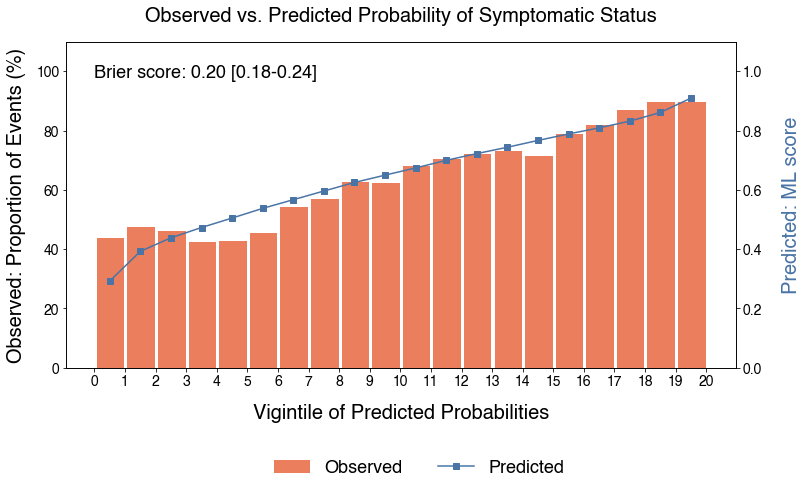

In [991]:
plt.rcParams["font.family"] = "Helvetica"

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

#ebm = load_obj("../output/fitted_models/ebm_all.pkl")
#y_pred_proba = ebm.predict_proba(X_test)[:, 1]
y_test_cv = probas["ML-All"]["gt_conc"]
y_pred_proba_test_cv = probas["ML-All"]["probas_conc"][:, 1]

fig, ax = hosmer_lemeshow_plot(y_test_cv, y_pred_proba_test_cv, 
                          n_bins=20, 
                          colors=[blue_yonder, sienna],
                          annotate_bars = False,
                          ax = ax)

ax.text(0, 98, "Brier score: 0.20 [0.18-0.24]", clip_on=False, fontsize=18)



plt.savefig("../output/plots/calibration.tiff", format="tiff", dpi=500,
                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

plt.show()

# Compute thresholds

## Definitions

In [771]:
def get_youden_all_models(cv_preds, on="train"):
    thresholds = dict()
    for algo_name in cv_preds.keys():
        res = get_sens_spec_youden(cv_preds, algo_name, 
                                   ret_cis=True,
                                   on = on)
        print(f"Youden's J for {algo_name}: {res['thresh']:.4f}")
        thresholds[algo_name] = res['thresh']
        
    return thresholds

## Computation

In [833]:
thresholds = get_youden_all_models(probas, on="train")

Youden's J for ML-All: 0.6363
Youden's J for ML-Clinical: 0.6531
Youden's J for ML-Calcification: 0.6309
Youden's J for LR-All: 0.6527


# ROC and PR curves

## Definitions

In [1025]:
from sklearn.metrics import roc_auc_score
from scikits.bootstrap import bootstrap_indices as scikits_boot_indices

def plot_average_roc_curves(cv_preds, 
                            ax, color, model_keys, 
                            show_ci, n_boot,
                            bars_pos=[0.41,0.01,0.53,0.30],
                            random_state = 1234):

    rng = np.random.RandomState(random_state)
    auc_cis = dict()
    for j, (algo_name, outer_cv_data) in enumerate(cv_preds.items()):
        fprs = np.linspace(0, 1, 100)
        tprs = []
        aucs = []
        
        gts = outer_cv_data['gt']
        probas = outer_cv_data['probas']
        
        for split_idx, (split_gts, split_probas) in enumerate(zip(gts, probas)):
            auc_val = roc_auc_score(split_gts, split_probas[:, 1])
            aucs.append(auc_val)

            # compute ROC curve components
            fpr, tpr, _ = roc_curve(split_gts, split_probas[:, 1])
            interp_tpr = np.interp(fprs, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            

        #tprs = np.array(tprs)
        mean_tprs = np.mean(tprs, axis=0)
        mean_tprs[-1] = 1.0
        std_tprs = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tprs + std_tprs, 1)
        tprs_lower = mean_tprs - std_tprs

        fpr, tpr, thresholds = roc_curve(outer_cv_data['gt_conc'], 
                                         outer_cv_data['probas_conc'][:, 1])              
        
        auc_low, auc_med, auc_up = np.percentile(aucs, [2.5, 50, 97.5])
        auc_cis[algo_name] = {"auc": auc_med, "ci_low": auc_low, "ci_up": auc_up}
        
        ax.plot(fpr,
                tpr,
                linestyle='-',
                alpha=1.0,
                linewidth=2,
                color=colors[j])       
        
        if show_ci:
            bootstrap_indices  = list(scikits_boot_indices(data=outer_cv_data['probas_conc'],
                                                           n_samples = n_boot,
                                                           seed = random_state))           

            bootstrap_tprs = []
            for i in range(n_boot):
                sample_gt = outer_cv_data['gt_conc'][bootstrap_indices[i]]
                sample_pred = outer_cv_data['probas_conc'][bootstrap_indices[i]][:, 1]

                bootstrap_fpr, bootstrap_tpr, bootstrap_thresholds = roc_curve(sample_gt, sample_pred)

                # interpolate the bootstrapped fpr using the fpr based on accumulated
                # ground-truths and predicted probabilities
                interp_tpr = np.interp(fpr, bootstrap_fpr, bootstrap_tpr)
                interp_tpr[0] = 0.0

                bootstrap_tprs.append(interp_tpr)

            bootstrap_tprs = np.stack(bootstrap_tprs)

            tpr_lower = np.percentile(bootstrap_tprs, 2.5, axis=0)
            tpr_upper = np.percentile(bootstrap_tprs, 97.5, axis=0)

            ax.fill_between(fpr, tpr_lower, tpr_upper, alpha=0.13,
                           color = colors[j])        

    ax.set_xlabel('1 - Specificity',
                  fontdict={"weight": "normal", "size": 26},
                  labelpad=20)
    ax.set_ylabel('Sensitivity',
                  fontdict={"weight": "normal", "size": 26},
                  labelpad=20)

    ax.xaxis.set_tick_params(labelsize=23)
    ax.yaxis.set_tick_params(labelsize=23)
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label="Baseline", alpha=.8)
    
    ins = ax.inset_axes(bars_pos)
    ins.spines['top'].set_visible(False)
    ins.spines['right'].set_visible(False)
    ins.spines['bottom'].set_visible(False)
    
    ins.get_xaxis().set_ticks([])
    
    model_names = model_keys
    model_aucs = [v["auc"] for _, v in auc_cis.items()]
    model_cis_low = np.array([v["auc"] - v["ci_low"] for _, v in auc_cis.items()])
    model_cis_up = np.array([v["ci_up"] - v["auc"] for _, v in auc_cis.items()])
    
    all_data = list(zip(model_names, model_aucs, model_cis_low, model_cis_up, colors))
    all_data.sort(key=lambda x: x[1], reverse=False)
    
    model_names = [t[0] for t in all_data]
    model_aucs = [t[1] for t in all_data]
    model_cis_low = [t[2] for t in all_data]
    model_cis_up = [t[3] for t in all_data]
    model_colors = [t[4] for t in all_data]

    bars = ins.barh(range(4), model_aucs, 
             xerr=[model_cis_low, model_cis_up], 
             align="center",
             color=model_colors,
             capsize=3,
             error_kw=dict(linewidth=1)
            )
    ins.invert_yaxis()
    ins.set_yticks(range(4), labels=model_names, fontsize=16)
    
    for i, (name, auc, bar) in enumerate(zip(model_names, model_aucs, ins.patches)):
        ins.annotate(f"{auc:.2f}",
                    (bar.get_width(),
                     bar.get_y() + bar.get_height() / 2), ha='left', va='center',
                    size=20, 
                     #xytext=(17, -1) if name != "Clinical" else (32,-1),
                     xytext=(0.04, i), color="w" if name != "" else "#000",
                    #textcoords='offset points'
                     textcoords='data'
                    )
    ins.set_title("AUC (bars) and 95% CI (whiskers)", 
                  fontsize=18, 
                  fontweight = "bold",
                  position=(0.4, 0.5))
    
    return ax, ins, bars, auc_cis

In [1024]:
from sklearn.metrics import average_precision_score, precision_recall_curve
from scikits.bootstrap import bootstrap_indices as scikits_boot_indices

def plot_average_pr_curves(cv_preds, 
                           ax, 
                           color, 
                           model_keys, 
                           show_ci, 
                           n_boot, 
                           bars_pos=[0.32,0.01,0.6,0.24],
                           random_state = 1234):

    rng = np.random.RandomState(random_state)
    auc_cis = dict()
    
    for j, (algo_name, outer_cv_data) in enumerate(cv_preds.items()):
        precisions = []
        recalls = np.linspace(0, 1, 100)
        pr_aucs = []
        
        gts = outer_cv_data['gt']
        probas = outer_cv_data['probas']

        for split_idx, (split_gts, split_probas) in enumerate(zip(gts, probas)):
            pr_auc = average_precision_score(split_gts, split_probas[:, 1])
            pr_aucs.append(pr_auc)

            # compute ROC curve components
            precision, recall, _ = precision_recall_curve(split_gts, split_probas[:, 1])
            precision, recall = precision[::-1], recall[::-1]

            prec_array = np.interp(recalls, recall, precision)
            precisions.append(prec_array)

        mean_prec = np.mean(precisions, axis=0)
        std_prec = np.std(precisions, axis=0)

        prec, rec, _ = precision_recall_curve(outer_cv_data['gt_conc'], 
                                              outer_cv_data['probas_conc'][:, 1])

        pr_auc_low, pr_auc_med, pr_auc_up = np.percentile(pr_aucs, [2.5, 50, 97.5])
        auc_cis[algo_name] = {"auc": pr_auc_med, "ci_low": pr_auc_low, "ci_up": pr_auc_up}

        ax.plot(rec,
                prec,
                alpha=1.0,
                color=colors[j],
        )
        
        if show_ci:
            bootstrap_indices  = list(scikits_boot_indices(data=outer_cv_data['probas_conc'],
                                                           n_samples = n_boot,
                                                           seed = random_state)) 

            bootstrap_precisions = []
            for i in range(n_boot):
                sample_gt = outer_cv_data['gt_conc'][bootstrap_indices[i]]
                sample_pred = outer_cv_data['probas_conc'][bootstrap_indices[i]][:, 1]

                bootstrap_precision, bootstrap_recall, _ = precision_recall_curve(sample_gt, sample_pred)
                bootstrap_precision, bootstrap_recall = bootstrap_precision[::-1], bootstrap_recall[::-1] # this was the key
                # interpolate the bootstrapped fpr using the fpr based on accumulated
                # ground-truths and predicted probabilities
                interp_precision = np.interp(rec, bootstrap_recall, bootstrap_precision)
                interp_precision[0] = 0.0

                bootstrap_precisions.append(interp_precision)

            bootstrap_precisions = np.stack(bootstrap_precisions)

            precision_lower = np.percentile(bootstrap_precisions, 2.5, axis=0)
            precision_upper = np.percentile(bootstrap_precisions, 97.5, axis=0)

            ax.fill_between(rec, precision_lower, precision_upper, alpha=0.13,
                           color = colors[j])        
        
    ax.set_xlabel('Recall',
                  fontdict={"weight": "normal", "size": 26},
                  labelpad=20)
    ax.set_ylabel('Precision',
                  fontdict={"weight": "normal", "size": 26},
                  labelpad=20)

    ax.xaxis.set_tick_params(labelsize=23)
    ax.yaxis.set_tick_params(labelsize=23)    

    # draw baseline
    tot_pos = outer_cv_data['gt_conc'].sum()
    tot = len(outer_cv_data['gt_conc'])
    baseline = tot_pos / tot
    plt.axhline(y=baseline, color='gray', linestyle='--', lw=1, alpha=.8,
                label='Baseline')
    
    ins = ax.inset_axes(bars_pos)
    ins.spines['top'].set_visible(False)
    ins.spines['right'].set_visible(False)
    ins.spines['bottom'].set_visible(False)
    
    ins.get_xaxis().set_ticks([])
    
    model_names = model_keys
    model_aucs = [v["auc"] for _, v in auc_cis.items()]
    model_cis_low = np.array([v["auc"] - v["ci_low"] for _, v in auc_cis.items()])
    model_cis_up = np.array([v["ci_up"] - v["auc"] for _, v in auc_cis.items()])
    
    all_data = list(zip(model_names, model_aucs, model_cis_low, model_cis_up, colors))
    all_data.sort(key=lambda x: x[1], reverse=False)
    
    model_names = [t[0] for t in all_data]
    model_aucs = [t[1] for t in all_data]
    model_cis_low = [t[2] for t in all_data]
    model_cis_up = [t[3] for t in all_data]
    model_colors = [t[4] for t in all_data]

    bars = ins.barh(range(4), model_aucs, 
             xerr=[model_cis_low, model_cis_up], 
             align="center",
             color=model_colors,
             capsize=3,
             error_kw=dict(linewidth=1)
            )    
    
    ins.invert_yaxis()
    ins.set_yticks(range(4), labels=model_names, fontsize=16)

    for i, (name, auc, bar) in enumerate(zip(model_names, model_aucs, ins.patches)):
        ins.annotate(f"{auc:.2f}",
                    (bar.get_width(),
                     bar.get_y() + bar.get_height() / 2), ha='left', va='center',
                    size=20, 
                     #xytext=(55, -1) if name != "Clinical" else (50,-1),
                     xytext=(0.04, i), color="w" if name != "" else "#000",
                    #textcoords='offset points'
                     textcoords='data'
                    )
    ins.set_title("AP (bars) and 95% CI (whiskers)", 
                  fontsize=18, 
                  fontweight = "bold",
                  position=(0.4, 0.5))
    
    return ax, ins, bars, auc_cis

In [804]:
from matplotlib import patches
def annot_stat_vertical(text, x, y1, y2, ww, 
                        col='k', 
                        fontsize=13, 
                        voffset = 0, 
                        n_elems = None,
                        ax=None,
                        **kwargs):
    """
    ww: float
        whisker width
    """
    ax = plt.gca() if ax is None else ax
    
    # we want the text to be centered on the whisker 
    text_x_pos = x + ww 
    #+ 0.01
    text_y_pos = (y1+y2)/2
    
    # draw whisker from y1 to y2 with width `ww`
    ax.plot([x, x + ww, x + ww, x], [y1, y1, y2, y2], lw=1, c=col)
    
    if len(text) == 1:                
        #text_y_pos = (y1+y2)/2

        # draw text at (text_x_pos, text_y_pos) # + 0.15
        ax.text(
            text_x_pos, (text_y_pos - voffset) + 0.17, text, 
            ha='center', va='center', color=col,
            size=fontsize, zorder=10
        )

        # Rectangle's props
        rect_h_base = kwargs.get("rect_h_base", 0.1)
        rect_w = 0.05 - (0.375 * 0.05) # on a scale from 0 to 1
        rect_h = rect_h_base * n_elems # transform to scale from 0 to n_elems-1
        rect_x_offset = -0.002
        rect_y_offset = 0.01 # move rectangle to the bottom. (0,0) is top left in the inserted barplot
        
        # draw white rectangle and put it beneath the text 
        # specifying a zorder inferior to that of the text
        rect = patches.Rectangle(
            (
                text_x_pos - (rect_w/2) + rect_x_offset, 
                text_y_pos - (rect_h/2) + rect_y_offset
            ),
            width = rect_w, height = rect_h, 
            linewidth=1, 
            edgecolor='w', 
            facecolor='w',
            zorder=9
        )
        
        ax.add_patch(rect)
    else:
        fontsize_nonsignif = kwargs.pop("fontsize_nonsignif", fontsize)
        ax.text(
            text_x_pos, text_y_pos, text, 
            ha='center', va='center', color=col,
            size=fontsize_nonsignif, zorder=10,
            bbox=dict(
                boxstyle='square,pad=0', 
                facecolor="white", 
                edgecolor="white"
            )
        )        

In [805]:
from matplotlib import patches
def annot_stat_horizontal(text, x1, x2, y, wh, col='k', fontsize=13, 
                        voffset = 0, 
                        n_elems = None,
                        ax=None,
                        **kwargs):
    """
    ww: float
        whisker width
    """
    ax = plt.gca() if ax is None else ax
    
    # we want the text to be centered on the whisker 
    text_y_pos = y + wh
    #+ 0.01 
    text_x_pos = (x1+x2)/2
    
    # draw whisker from y1 to y2 with width `ww`
    ax.plot([x1, x1, x2, x2], [y, y + wh, y + wh, y], lw=1, c=col,
           clip_on=False)
    
    if len(text) == 1:     
        #text_y_pos = (y1+y2)/2

        # draw text at (text_x_pos, text_y_pos) # + 0.15
        ax.text(
            text_x_pos, text_y_pos + voffset, text, 
            ha='center', va='center', color=col,
            size=fontsize, zorder=10
        )

        # Rectangle's props
        rect_w = 0.09 # transform to scale from 0 to n_elems-1        
        rect_h = 0.05 - (0.375 * 0.05) # on a scale from 0 to 1
        rect_x_offset = 0.005
        rect_y_offset = -0.001 # move rectangle to the bottom. (0,0) is top left in the inserted barplot
        
        # draw white rectangle and put it beneath the text 
        # specifying a zorder inferior to that of the text
        rect = patches.Rectangle(
            (
                text_x_pos - (rect_w/2) + rect_x_offset, 
                text_y_pos - (rect_h/2) + rect_y_offset
            ),
            width = rect_w, height = rect_h, 
            linewidth=1, 
            edgecolor='w', 
            facecolor='w',
            zorder=9,
            clip_on=False
        )
        
        ax.add_patch(rect)
    else:
        fontsize_nonsignif = kwargs.pop("fontsize_nonsignif", fontsize)
        ax.text(
            text_x_pos, text_y_pos, text, 
            ha='center', va='center', color=col,
            size=fontsize_nonsignif, zorder=10,
            bbox=dict(
                boxstyle='square,pad=0', 
                facecolor="white", 
                edgecolor="white"
            )
        )        

In [1015]:
from typing import Tuple, List, Dict

def add_annotations(comparisons: Dict[str, Tuple[str, str, float]], 
                    alpha: float, 
                    bars: matplotlib.container.BarContainer,
                    direction: str,
                    order: List[Tuple[str, str]],
                    symbol: str,
                    symbol_fontsize: float = 22,
                    voffset: float = 0,
                    ax: plt.Axes = None,
                    **kwargs):
    if not ax:
        raise ValueError("I need an Axes to draw comparisons on.")
    
    comparisons_list = []
    if order:
        for fst_algo, snd_algo in order:
            cmp_key = f"{fst_algo}_{snd_algo}"
            cmp = comparisons.get(cmp_key, None)
            if not cmp:
                raise ValueError(f"The comparison {cmp_key} does not exist in the order list.")
            comparisons_list.append(cmp)
    else:
        comparisons_list = list(comparisons.values())
        
    
    if direction == "horizontal":
        width = bars[0].get_width()
        entity_labels = ax.get_xticklabels()
        entity_idx = {label.get_text(): (i + 0.03) for i, label in enumerate(entity_labels)}
        
        whisker_y_offset = kwargs.pop("whisker_y_offset", 0)
        y_lim_upper = ax.get_ylim()[1] + 0.05 + whisker_y_offset
        v_offset = 0.07

        for i, (fst_model, snd_model, P) in enumerate(comparisons_list):
            P_str = symbol if P <= alpha else f"{P:.3f}"
            annot_stat_horizontal(text=P_str, 
                                x1=entity_idx[fst_model] + width/2, 
                                x2=entity_idx[snd_model] + width/2, 
                                y=(y_lim_upper - 0.17) + (i * v_offset), # overall distance from top of bars and upper limit of y + inter-distance between whiskers
                                wh=0.02,
                                col="black", 
                                fontsize=symbol_fontsize,
                                voffset = -0.02,
                                n_elems = len(entity_labels),
                                ax=ax,
                                **kwargs)
    elif direction == "vertical":
        height = bars[0].get_height()
        entity_labels = ax.get_yticklabels()
        entity_idx = {label.get_text(): (i + 0.03) for i, label in enumerate(entity_labels)}

        x_lim_upper = ax.get_xlim()[1] + 0
        h_offset = 0.07
        
        for i, (fst_model, snd_model, P) in enumerate(comparisons_list):
            P_str = symbol if P <= alpha else f"{P:.3f}"
            annot_stat_vertical(text=P_str,
                                x=x_lim_upper + (i * h_offset),  
                                y1=entity_idx[fst_model], 
                                y2=entity_idx[snd_model],                                  
                                ww=0.02,
                                col="black", 
                                fontsize=symbol_fontsize,
                                n_elems = len(entity_labels),
                                voffset = voffset,
                                ax=ax,
                                **kwargs)        
    
    return ax

In [21]:
def roc_single_comparison(cv_preds, fst_algo, snd_algo):
    ground_truths = cv_preds[fst_algo]["gt_conc"]
    fst_algo_probas = cv_preds[fst_algo]["probas_conc"][:, 1]
    snd_algo_probas = cv_preds[snd_algo]["probas_conc"][:, 1]
    
    P = delong_roc_test(ground_truths, fst_algo_probas, snd_algo_probas)
    cmp_key = f"{fst_algo}_{snd_algo}"
    return {cmp_key: (fst_algo, snd_algo, P)}
        
def roc_comparisons(cv_preds, target_algo):
    comparisons = dict()

    for algo_name in cv_preds.keys():
        if algo_name != target_algo:
            cmp = roc_single_comparison(cv_preds, target_algo, algo_name)
            comparisons = dict(cmp, **comparisons)
            
    return comparisons            

In [814]:
from typing import Callable
from scipy.stats import ttest_ind
from sklearn.metrics import average_precision_score

def ap_single_comparison(cv_preds, fst_algo, snd_algo):
    # iterate over ground-truths and predicted probas of cv splits
    fst_algo_aps, snd_algo_aps = [], []
    
    
    for it in range(len(cv_preds[fst_algo]["gt"])):
        ground_truths = cv_preds[fst_algo]["gt"][it]
        fst_algo_probas = cv_preds[fst_algo]["probas"][it]
        snd_algo_probas = cv_preds[snd_algo]["probas"][it]
        fst_algo_ap = average_precision_score(ground_truths, fst_algo_probas[:, 1])
        snd_algo_ap = average_precision_score(ground_truths, snd_algo_probas[:, 1])
        
        fst_algo_aps.append(fst_algo_ap)
        snd_algo_aps.append(snd_algo_ap)
    
    t_statistic, p_value = ttest_ind(fst_algo_aps, snd_algo_aps)
    cmp_key = f"{fst_algo}_{snd_algo}"
    return {cmp_key: (fst_algo, snd_algo, p_value)}
        
def ap_comparisons(cv_preds, target_algo):
    comparisons = dict()

    for algo_name in cv_preds.keys():
        if algo_name != target_algo:
            cmp = ap_single_comparison(cv_preds, target_algo, algo_name)
            comparisons = dict(cmp, **comparisons)
            
    return comparisons            

## Plot

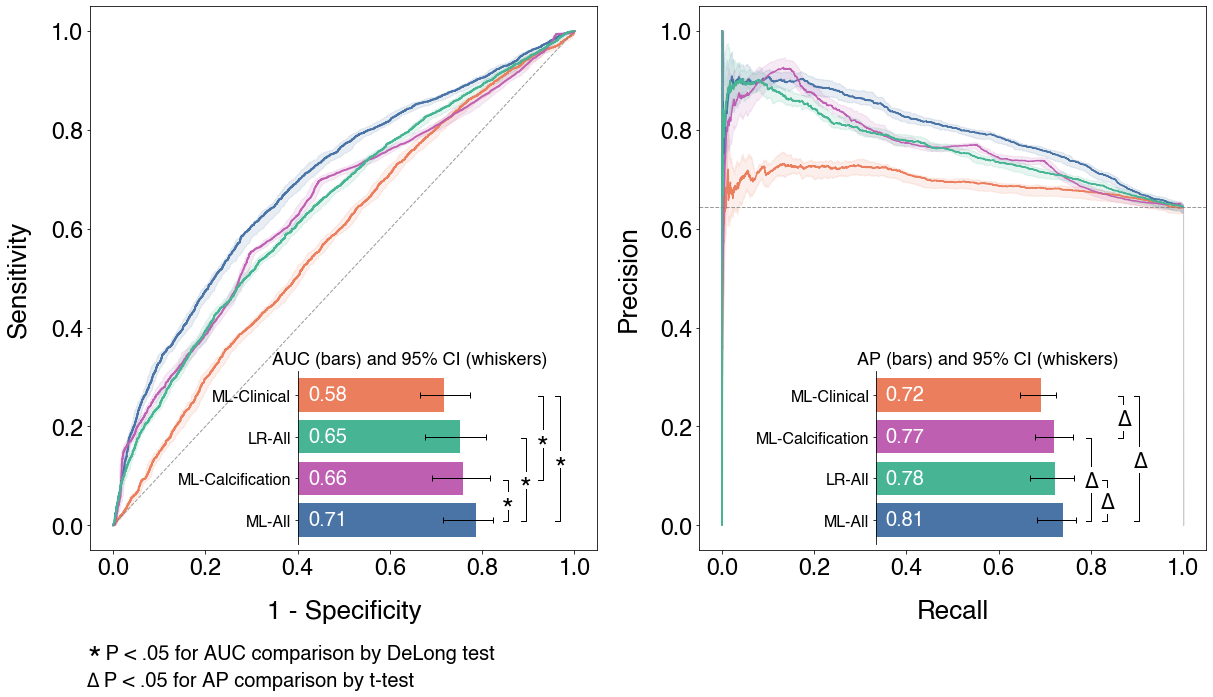

In [1382]:
model_names = list(probas.keys())
alpha = 0.05
alph_str = str(alpha).split(".")[1]
alpha_formatted = f".{alph_str}"
roc_symbol = "*"
ap_symbol = "∆"
n_boot = 10

f, axes = plt.subplots(1, 2, figsize=(20, 10))

ax1, barplot_roc, bars_roc, roc_aucs_data = plot_average_roc_curves(probas, 
                                                                    axes[0], 
                                                                    color=colors, 
                                                                    model_keys=model_names,
                                                                    show_ci = True,
                                                                    n_boot = n_boot,
                                                                    bars_pos=[0.41,0.01,0.55,0.32],
                                                                    random_state=seed)

# run comparison between AUROCs of ML-All and all other algorithms
roc_comparisons_results = roc_comparisons(probas, "ML-All")

# manually add a comparison
cmp = roc_single_comparison(probas, "ML-Calcification", "ML-Clinical")
roc_comparisons_results = dict(cmp, **roc_comparisons_results)

order = [
    ("ML-All", "ML-Calcification"),
    ("ML-All", "LR-All"),
    ("ML-Calcification", "ML-Clinical"),
    ("ML-All", "ML-Clinical"),
]

ax1 = add_annotations(roc_comparisons_results, 
                      alpha = 0.05, 
                      bars=bars_roc, 
                      direction = "vertical",
                      order = order,
                      symbol = roc_symbol,
                      symbol_fontsize = 30,
                      voffset = -0.07,
                      ax=barplot_roc)

ax2, barplot_pr, bars_pr, pr_aucs_data = plot_average_pr_curves(probas, 
                                                                axes[1], 
                                                                color=colors, 
                                                                model_keys=model_names,
                                                                show_ci = True,
                                                                n_boot = n_boot,                                                                
                                                                bars_pos=[0.35,0.01,0.55,0.32],
                                                                random_state=seed)

# run comparison between APs of ML-All and all other algorithms
ap_comparisons_results = ap_comparisons(probas, "ML-All")

# manually add a comparison
cmp = ap_single_comparison(probas, "ML-Calcification", "ML-Clinical")
ap_comparisons_results = dict(cmp, **ap_comparisons_results)

cmp = ap_single_comparison(probas, "ML-Calcification", "ML-Clinical")
ap_comparisons_results = dict(cmp, **ap_comparisons_results)

kwargs = dict(rect_h_base = 0.15)
ax2 = add_annotations(ap_comparisons_results, 
                      alpha = 0.05, 
                      bars=bars_pr, 
                      direction = "vertical",
                      order = order,
                      symbol = ap_symbol,
                      voffset = 0.11,
                      ax=barplot_pr,
                      **kwargs)

axes[0].text(-0.005, -0.22, f"{roc_symbol}", clip_on=False, fontsize=35,
             transform=axes[0].transAxes)
axes[0].text(0.02, -0.20, f" P < {alpha_formatted} for AUC comparison by DeLong test", clip_on=False, 
             fontsize=20,
            transform=axes[0].transAxes)
axes[0].text(-0.009, -0.25, f"{ap_symbol} P < {alpha_formatted} for AP comparison by t-test", clip_on=False, 
             fontsize=20,
            transform=axes[0].transAxes)

plt.savefig("../output/plots/roc_pr_curves.tiff", format="tiff", dpi=500,
                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

In [1374]:
roc_aucs_data

{'ML-All': {'auc': 0.7105645706558485,
  'ci_low': 0.5804621848739496,
  'ci_up': 0.7812324929971988},
 'ML-Clinical': {'auc': 0.582983193277311,
  'ci_low': 0.4884721095334686,
  'ci_up': 0.68953081232493},
 'ML-Calcification': {'auc': 0.6601890756302521,
  'ci_low': 0.5347122210953347,
  'ci_up': 0.7686011904761904},
 'LR-All': {'auc': 0.6482843137254901,
  'ci_low': 0.5081331135902637,
  'ci_up': 0.7528038249782671}}

In [1375]:
pr_aucs_data

{'ML-All': {'auc': 0.8141244786669695,
  'ci_low': 0.7013491729243917,
  'ci_up': 0.8729349780815262},
 'ML-Clinical': {'auc': 0.7181481390495723,
  'ci_low': 0.6284505753208783,
  'ci_up': 0.7828666374614088},
 'ML-Calcification': {'auc': 0.7747687535200847,
  'ci_low': 0.6920627334206364,
  'ci_up': 0.8575556790996862},
 'LR-All': {'auc': 0.7787991143991042,
  'ci_low': 0.6697000166492963,
  'ci_up': 0.8627081370768233}}

# Feature importance

## Definitions

In [1278]:
from matplotlib.patches import Patch

def plot_feature_importance(model, subsets, colors, columns_map, legend_labels, ax, **kwargs):
    if not ax:
        f, ax = plt.subplots(figsize=(3, 6))
        
    # TODO: make sure model is a fitted EBM
    model_global = model.explain_global()
    
    imps = model_global.data()
    imps = list(zip(imps["names"], imps["scores"]))
    imps.sort(key=lambda x:x[1], reverse=True)
    
    interaction_color = kwargs.pop("interaction_color", "#E31B23")
    bar_colors = []
    for (imp_name, _) in imps:
        subset_found = False
        for subset, subset_color in zip(subsets, colors):
            if imp_name in subset:
                bar_colors.append(subset_color)
                subset_found = True
        if not subset_found: # it's an interaction feature
            bar_colors.append(interaction_color)
                
    
    feat_imp = ax.barh(range(len(imps)), [i[1] for i in imps], color=bar_colors)
    ax.invert_yaxis()
    #ax.tick_params(axis='x', labelsize=14)
    
    feature_labels = []
    for feature_name, _ in imps:
        # try finding the label in COLUMNS_MAP
        lab = columns_map.get(feature_name, None)
        if lab:
            feature_labels.append(lab)
        else:
            parts = list(map(lambda v: v.replace(" ", ""), feature_name.split("&")))
            lab = f"{columns_map.get(parts[0])} & {columns_map.get(parts[1])}"
            feature_labels.append(lab)
            
    ax.set_yticks(range(len(imps)), labels=feature_labels, fontsize=14)
    ax.set_xticks([], [])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)


    #ax.get_xaxis().set_ticks([])
    ax.set_xlabel("Average absolute impact", fontsize=18)
    ax.xaxis.labelpad = 10

    
    legend_handles = []
    for subset_name, subset_color in zip(legend_labels, colors):
        legend_handles.append(Patch(facecolor=subset_color, 
                                    edgecolor="white",
                                    label=subset_name))
    # Add handle for Interaction features
    legend_handles.append(Patch(facecolor=interaction_color, 
                                edgecolor="white",
                                label="Interaction"))
    
    
    ax.get_figure().legend(handles=legend_handles, 
                           frameon=False, 
                           bbox_to_anchor=(1.05, 0.07), 
                           ncol=3,
                           prop={"size": 16})

    #plt.margins(y=0)
    ax.margins(y=0)
    
    return ax.get_figure(), ax

## Plot

In [66]:
ebm_all = load_obj("../output/fitted_models/ebm_all.pkl")

In [67]:
clinical_subset = list(filter(lambda c: "calcification" not in c, X_test.columns))
calcification_subset = set(X_test.columns).difference(set(clinical_subset))

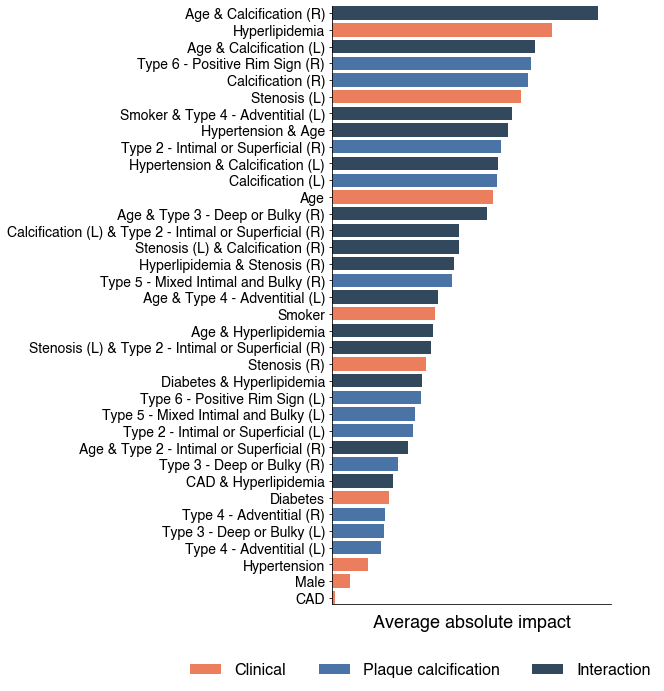

In [1279]:
subsets = [clinical_subset, calcification_subset]
feat_imp_colors = [sienna, blue_yonder]
legend_labels = ["Clinical", "Plaque calcification"]

f, ax = plt.subplots(figsize=(5, 11))
kwargs = dict(interaction_color = charcoal)
_ , ax = plot_feature_importance(ebm_all, subsets, feat_imp_colors, COLUMNS_MAP, legend_labels, ax, **kwargs)

plt.savefig("../output/plots/importance_all.tiff", format="tiff", dpi=500,
                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

plt.show()

# Sensitivity and specificity barplot

## Definitions

In [1438]:
def prep_sens_spec_old(cv_preds, model_names_labels, 
                   custom_labels_extraction = None,
                   pos_class_idx = 1):
    """
    This function prepares the data necessary to plot sensitivity
    and specificity bars along with comparisons according to
    the McNemar test.
    
    Parameters:
    -----------
    cv_preds:
    
    Returns:
    --------
    sens_spec: Dict
    labels_symptomatic: Dict
    
    """
    labels_pos_class = dict()
    sens_spec = dict()
    
    for algo_name in model_names_labels:
        if algo_name not in sens_spec:
            sens_spec[algo_name] = {"sensitivities": [], "specificities": []}
        if algo_name not in labels_pos_class:
            labels_pos_class[algo_name] = []
        
        # gt and probas of validation folds
        ground_truths = cv_preds[algo_name]["gt"]
        algo_probas = cv_preds[algo_name]["probas"]
        
        for i, (gts, probas) in enumerate(zip(ground_truths, algo_probas)):
            if custom_labels_extraction:
                labels = custom_labels_extraction(probas)
            else:
                pos_class_probas = probas[:, pos_class_idx]
                
                # compute Youden's J on training gts and pred probas
                #fpr, tpr, thresholds = roc_curve(cv_preds[algo_name]["gt_train"][i], 
                #                                 cv_preds[algo_name]["probas_train"][i][:, pos_class_idx])
                #idx = np.argmax(tpr - fpr)
                #thresh = thresholds[idx]
                sens_spec_thresholds = compute_sens_spec_all_thresholds(cv_preds[algo_name]["gt_train"][i], 
                                                                        cv_preds[algo_name]["probas_train"][i][:, pos_class_idx])
                thresh, sensitivity, specificity = threshold_analysis(cv_preds[algo_name]["gt_train"][i], 
                                                                      cv_preds[algo_name]["probas_train"][i][:, pos_class_idx],
                                                                      res = sens_spec_thresholds,
                                                                      mode = ("sensitivity", 0.9))
                
                # take labels using Youden's J for thresholding
                # predicted probabilities of the positive class
                labels = np.where(pos_class_probas >= thresh, 1, 0)
                labels_pos_class[algo_name].append(labels)
            
            tn, fp, fn, tp = confusion_matrix(gts, labels).ravel()

            #sensitivity = tp / (tp + fn)
            #specificity = tn / (tn + fp)

            sens_spec[algo_name]["sensitivities"].append(sensitivity)
            sens_spec[algo_name]["specificities"].append(specificity)    
    
    for algo_name in model_names_labels:
        mean_sens = np.mean(sens_spec[algo_name]["sensitivities"])
        sens_low, sens_up = np.percentile(sens_spec[algo_name]["sensitivities"], [2.75, 97.5])
        sens_spec[algo_name] = dict(sens_spec[algo_name], **{"mean_sens": mean_sens,
                                                            "sens_low": sens_low,
                                                            "sens_up": sens_up})
        mean_spec = np.mean(sens_spec[algo_name]["specificities"])
        spec_low, spec_up = np.percentile(sens_spec[algo_name]["specificities"], [2.75, 97.5])
        sens_spec[algo_name] = dict(sens_spec[algo_name], **{"mean_spec": mean_spec,
                                                            "spec_low": spec_low,
                                                            "spec_up": spec_up})   
    
    return sens_spec, labels_pos_class

In [870]:
from collections import namedtuple

ThresholdPerf = namedtuple("ThresholdPerf", ["threshold", 
                                             "sensitivity", 
                                             "specificity",
                                             "tn", "fp", "fn", "tp"]) 

def confusion_matrix_eff(y_true, y_pred):
    N = 2
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1) 

    y = N * y_true + y_pred
    y = np.bincount(y, minlength=N*N)
    y = y.reshape(N, N)
    return y

def compute_sens_spec_all_thresholds(gt_train, probas_train,
                                     gt_val, probas_val):
    # compute thresholds on training data
    fpr, tpr, thresholds = roc_curve(gt_train, probas_train)

    res = dict()

    # iterate over thresholds and compute labels on validation data
    for t in thresholds:
        pred_labels = np.where(probas_val >= t, 1, 0)

        tn, fp, fn, tp = confusion_matrix_eff(gt_val, pred_labels).ravel()

        sens = tp / (fn + tp)
        spec = tn / (fp + tn)    
        
        # sensitivity and specificity refer to validation data
        res[t] = ThresholdPerf(t, sens, spec, tn, fp, fn, tp)
        
    return res

def threshold_analysis(gt_train, probas_train,
                       gt_val, probas_val,
                       res,
                       mode: str):
    if not res:
        res = compute_sens_spec_all_thresholds(gt_train, probas_train,
                                               gt_val, probas_val)

    to_return = None
    if mode == "max_sensitivity":
        to_return = max(res.items(), key=lambda t: t[1].sensitivity)
    elif mode == "max_specificity":
        to_return = max(res.items(), key=lambda t: t[1].specificity)
    elif isinstance(mode, tuple): # find threshold that gives at least ref value of metric
        metric, ref = mode
        if metric == "sensitivity":
            temp = list(filter(lambda t: t[1].sensitivity >= ref, res.items()))
            to_return = temp[0] if temp else None
        elif metric == "specificity":
            temp = list(filter(lambda t: t[1].specificity >= ref, res.items()))
            to_return = temp[-1] if temp else None           
    elif mode == "youden":
        fpr, tpr, thresholds = roc_curve(gt_train, probas_train)
        J = np.argmax(tpr - fpr)
        thresh = thresholds[J]
        pred_labels = np.where(probas_val >= thresh, 1, 0)

        tn, fp, fn, tp = confusion_matrix_eff(gt_val, pred_labels).ravel()

        sens = tp / (fn + tp)
        spec = tn / (fp + tn)    

        res = ThresholdPerf(thresh, sens, spec, tn, fp, fn, tp)
        to_return = (thresh, res)
    
    return to_return[1] if len(to_return) > 1 else None

In [912]:
from scipy.stats import binomtest
from scikits.bootstrap import ci as scikits_ci
from sklearn.metrics import confusion_matrix

def sens_fn(target, labels):
    tn, fp, fn, tp = confusion_matrix(target, labels).ravel()

    return tp / (fn + tp)

def spec_fn(target, labels):
    tn, fp, fn, tp = confusion_matrix(target, labels).ravel()

    return tn / (fp + tn)

def prep_sens_spec_new(cv_preds, model_names_labels, 
                   custom_labels_extraction = None,
                   pos_class_idx = 1,
                   mode: tuple = ("sensitivity", 0.9),
                   ci_method = "bootstrap", # only used when use_accumulated=True
                   n_boot = 1000, # only used if ci_method == "bootstrap"
                   use_accumulated: bool = False,
                   random_state = 1234):
    """
    This function prepares the data necessary to plot sensitivity
    and specificity bars along with comparisons according to
    the McNemar test.
    
    Parameters:
    -----------
    cv_preds:
    
    Returns:
    --------
    sens_spec: Dict
    labels_symptomatic: Dict
    
    """
    labels_pos_class = dict()
    sens_spec = dict()
    
    for algo_name in model_names_labels:
        if algo_name not in sens_spec:
            sens_spec[algo_name] = {"sensitivities": [], "specificities": []}
        if algo_name not in labels_pos_class:
            labels_pos_class[algo_name] = []
        
        
        if use_accumulated:
            # accumulated gt and probas of validation folds
            gt_conc_train = cv_preds[algo_name]["gt_conc_train"]
            probas_conc_train = cv_preds[algo_name]["probas_conc_train"][:, 1]
            gt_conc_val = cv_preds[algo_name]["gt_conc"]
            probas_conc_val = cv_preds[algo_name]["probas_conc"][:, 1]
            
            #sens_spec_thresholds = compute_sens_spec_all_thresholds(cv_preds[algo_name]["gt_conc_train"], 
            #                                                        cv_preds[algo_name]["probas_conc_train"][:, pos_class_idx])
            thresh, sensitivity, specificity, tn, fp, fn, tp = threshold_analysis(gt_conc_train, 
                                                                                  probas_conc_train,
                                                                                  gt_conc_val, 
                                                                                  probas_conc_val,
                                                                                  res = None,
                                                                                  mode = mode)                        
            if ci_method == "binom":
                # CI for sensitivity
                sens_test = binomtest(k=tp, n=(tp+fn), p=0.5)
                sens_low, sens_up = sens_test.proportion_ci(method="wilsoncc")

                # CI for specificity
                spec_test = binomtest(k=tn, n=(tn+fp), p=0.5)   
                spec_low, spec_up = spec_test.proportion_ci(method="wilsoncc")
            elif ci_method == "bootstrap":
                labels_val = np.where(cv_preds[algo_name]["probas_conc"][:, pos_class_idx] >= thresh, 1, 0)
                
                # sensitivity
                conf_int_sens, dist_sens = scikits_ci(data=(gt_conc_val, labels_val),
                                         statfunction=sens_fn,
                                         multi="paired",
                                         n_samples=n_boot,
                                         method="bca",
                                         seed=random_state,
                                         return_dist=True)
                sens_low, sens_up = conf_int_sens
                print(sens_low, sens_up)
                
                # specificity
                conf_int_spec, dist_spec = scikits_ci(data=(gt_conc_val, labels_val),
                                         statfunction=spec_fn,
                                         multi="paired",
                                         n_samples=n_boot,
                                         method="bca",
                                         seed=random_state,
                                         return_dist=True)                
                spec_low, spec_up = conf_int_spec

            
            
            sens_spec[algo_name] = {"mean_sens": sensitivity,
                                    "sens_low": sens_low,
                                    "sens_up": sens_up}            
            sens_spec[algo_name] = dict(sens_spec[algo_name], **{"mean_spec": specificity,
                                    "spec_low": spec_low,
                                    "spec_up": spec_up})   
            
            
            labels_val = np.where(cv_preds[algo_name]["probas_conc"][:, pos_class_idx] >= thresh, 1, 0)
            labels_pos_class[algo_name].append(labels_val)
        else:
            # gt and probas of validation folds
            ground_truths_train = cv_preds[algo_name]["gt_train"]
            ground_truths_val = cv_preds[algo_name]["gt"]
            algo_probas_train = cv_preds[algo_name]["probas_train"]
            algo_probas_val = cv_preds[algo_name]["probas"]
            
            for i, (gts_train, probas_train, gts_val, probas_val) in enumerate(zip(ground_truths_train, 
                                                                                   algo_probas_train,
                                                                                   ground_truths_val, 
                                                                                   algo_probas_val)):
                #pos_class_probas = probas[:, pos_class_idx]

                #sens_spec_thresholds = compute_sens_spec_all_thresholds(cv_preds[algo_name]["gt_train"][i], 
                #                                                        cv_preds[algo_name]["probas_train"][i][:, pos_class_idx])
                thresh, sensitivity, specificity, tn, fp, fn, tp = threshold_analysis(gts_train,
                                                                                      probas_train[:, 1],
                                                                                      gts_val,
                                                                                      probas_val[:, 1],
                                                                                      res = None,
                                                                                      mode = mode)
                # predict labels on validation data
                labels = np.where(probas_val[:, 1] >= thresh, 1, 0)
                labels_pos_class[algo_name].append(labels)

                sens_spec[algo_name]["sensitivities"].append(sensitivity)
                sens_spec[algo_name]["specificities"].append(specificity)    

    for algo_name in model_names_labels:
        if not use_accumulated:
            mean_sens = np.mean(sens_spec[algo_name]["sensitivities"])
            sens_low, sens_up = np.percentile(sens_spec[algo_name]["sensitivities"], [2.75, 97.5])        
            sens_spec[algo_name] = dict(sens_spec[algo_name], **{"mean_sens": mean_sens,
                                                                "sens_low": sens_low,
                                                                "sens_up": sens_up})
            mean_spec = np.mean(sens_spec[algo_name]["specificities"])
            spec_low, spec_up = np.percentile(sens_spec[algo_name]["specificities"], [2.75, 97.5])
            sens_spec[algo_name] = dict(sens_spec[algo_name], **{"mean_spec": mean_spec,
                                                                "spec_low": spec_low,
                                                                "spec_up": spec_up})   

    return sens_spec, labels_pos_class

In [33]:
def get_ground_truths(cv_preds):
    ground_truths = dict()
    
    for algo_name, algo_data in cv_preds.items():
        ground_truths[algo_name] = algo_data["gt_conc"]
        
    return ground_truths

In [34]:
from mlxtend.evaluate import mcnemar, mcnemar_table

def mcnemar_single_comparison(ground_truths, pred_labels, fst_algo, snd_algo):
    fst_algo_labels = np.concatenate(pred_labels[fst_algo])
    snd_algo_labels = np.concatenate(pred_labels[snd_algo])
    
    tb = mcnemar_table(y_target=ground_truths[fst_algo], 
                               y_model1=fst_algo_labels, 
                               y_model2=snd_algo_labels)
    chi2, mcnemar_P = mcnemar(ary=tb, corrected=True)
    
    cmp_key = f"{fst_algo}_{snd_algo}"
    return {cmp_key: (fst_algo, snd_algo, mcnemar_P)}
        
    
def mcnemar_comparisons(ground_truths, pred_labels, target_algo, algo_names):
    comparisons = dict()

    for algo_name in algo_names:
        if algo_name != target_algo:
            cmp = mcnemar_single_comparison(ground_truths, pred_labels, target_algo, algo_name)
            comparisons = dict(cmp, **comparisons)
            
    return comparisons

In [817]:
from typing import List
import matplotlib.patheffects as pe
from operator import itemgetter

def plot_sens_spec_ax(sens_spec, mcnemar_pvalues, 
                      colors: dict,
                      annot_colors: dict,
                      ax=None):
    if not ax:
        f, ax = plt.subplots(figsize=(10, 5))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)

    ax.get_xaxis().set_ticks([])

    w = 0.4

    # Sensitivity
    model_names = [k for k in sens_spec.keys()]
    model_sens = [v["mean_sens"] for _, v in sens_spec.items()]
    model_sens_low = np.array([v["mean_sens"] - v["sens_low"] for _, v in sens_spec.items()])
    model_sens_up = np.array([v["sens_up"] - v["mean_sens"] for _, v in sens_spec.items()])
    
    #all_data_sens = list(zip(model_names, 
    #                        model_sens, 
    #                        model_sens_low, 
    #                        model_sens_up))
    #all_data_sens.sort(key=lambda x: x[1])    

    #model_names = [t[0] for t in all_data_sens]
    #model_sens = [t[1] for t in all_data_sens]
    #model_sens_low = [t[2] for t in all_data_sens]
    #model_sens_up = [t[3] for t in all_data_sens]

    
    # Specificity
    model_spec = []
    model_spec_low = []
    model_spec_up = []

    # Follow the same order for specificity
    for model_name in model_names:
        mean_spec = sens_spec[model_name]["mean_spec"]
        model_spec.append(mean_spec)
        model_spec_low.append(mean_spec - sens_spec[model_name]["spec_low"])
        model_spec_up.append(sens_spec[model_name]["spec_up"] - mean_spec)
    
    # sort by sensitivity AND specificity, descending
    all_data_sens_spec = list(zip(model_sens, model_sens_low, model_sens_up,
                                  model_spec, model_spec_low, model_spec_up,
                                  model_names))
    all_data_sens_spec = sorted(all_data_sens_spec, key=itemgetter(0, 3)) #0: sens, 3: spec
    
    model_names = [t[-1] for t in all_data_sens_spec]
    model_sens = [t[0] for t in all_data_sens_spec]
    model_sens_low = [t[1] for t in all_data_sens_spec]
    model_sens_up = [t[2] for t in all_data_sens_spec] 
    
    model_spec = [t[3] for t in all_data_sens_spec]
    model_spec_low = [t[4] for t in all_data_sens_spec]
    model_spec_up = [t[5] for t in all_data_sens_spec]     
    
    # actually plot bars
    ## sensitivity
    bars_sens = ax.bar(np.arange(len(sens_spec.keys()))+w/2+0.03, 
                       model_sens, 
                         yerr=[model_sens_low, model_sens_up], 
                         align="center",
                         color=colors["sensitivity"],
                         capsize=3,
                         error_kw=dict(linewidth=1),
                         label="Sensitivity",
                         width=w
                        )

    ## specificity
    bars_spec = ax.bar(np.arange(len(sens_spec.keys()))-w/2-0.03, 
                       model_spec, 
                         yerr=[model_spec_low, model_spec_up], 
                         align="center",
                         color=colors["specificity"],
                         capsize=3,
                         error_kw=dict(linewidth=1),
                         label="Specificity",
                         width=w
                        )

    # Annotate sensitivity
    for i, (name, sens, bar, up) in enumerate(zip(model_names, 
                                                 model_sens, 
                                                 ax.patches, 
                                                 model_sens_up)):
        sens = (sens*100)
        ax.annotate(f"{sens:.1f}",
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                    ha='left', va='center',
                    size=18, 
                    xytext=(i+w/2+0.17, 0.06),
                    color=annot_colors.get("sensitivity", "#fff"), 
                    weight="bold", 
                    fontname="Helvetica",
                    textcoords='data') 


    # Annotate specificity
    for i, (name, spec, bar, up) in enumerate(zip(model_names, 
                                                 model_spec, 
                                                 ax.patches, 
                                                 model_spec_up)):
        spec = (spec*100)
        ax.annotate(f"{spec:.1f}",
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                    ha='left', va='center',
                    size=18, 
                    xytext=(i-w/2+0.1, 0.06),
                    color=annot_colors.get("specificity", "#fff"), 
                    weight="bold", 
                    fontname="Helvetica",
                    textcoords='data')
    
    ax.invert_xaxis()
    ax.set_xticks(np.arange(len(sens_spec.keys())), labels=model_names, fontsize=14)
    ax.set_ylabel("(%)", fontsize=14)
    ax.set_ylim([0, 1])
    ax.tick_params(axis='y', labelsize=14)    
    
    
    f.legend(frameon=False, ncol=2, 
             bbox_to_anchor=(0.70, 0.05), 
             fontsize=14,
             prop={"size": 16})
    
    return f, ax, {"bars_sens": bars_sens, "bars_spec": bars_spec}

## Plot
Determine the Youden's J statistic on the accumulated training data (gt_conc_train, probas_conc_train) and use it to derive labels on the validation data (gt_conc, probas_conc).

In [914]:
sens_spec, labels = prep_sens_spec_new(cv_preds=probas, 
                                   model_names_labels = list(probas.keys()), 
                                   custom_labels_extraction = None,
                                   use_accumulated=True,
                                   mode = ("sensitivity", 0.80),
                                   ci_method="bootstrap",
                                   n_boot = 1000,
                                   #mode = "youden",
                                   pos_class_idx = 1,
                                   random_state=seed)



gts = get_ground_truths(probas)
mcnemar_comparisons_results = mcnemar_comparisons(gts, labels, 
                                                  target_algo = "ML-All", 
                                                  algo_names = probas.keys())

# manually add a comparison
manual_cmp = mcnemar_single_comparison(gts, labels, "ML-Calcification", "ML-Clinical")
mcnemar_comparisons_results = dict(manual_cmp, **mcnemar_comparisons_results)

order = [
    ("ML-All", "ML-Calcification"),
    ("ML-All", "LR-All"),    
    ("ML-All", "ML-Clinical"),
    ("ML-Calcification", "ML-Clinical"),
]

0.7882632831086439 0.8104728409534975
0.788370253164557 0.8108002347877128
0.7911206727948367 0.8118426178418388
0.7894016425498631 0.8112874779541446


In [915]:
for algo_name in sens_spec.keys():
    sens_spec[algo_name]['mean_sens'] = round(sens_spec[algo_name]['mean_sens'], 2)

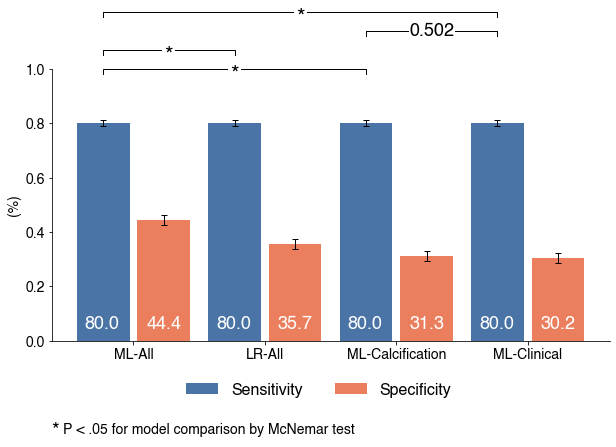

In [963]:
f, ax, bars = plot_sens_spec_ax(sens_spec, list(probas.keys()),
                          colors = {"sensitivity": blue_yonder, "specificity": sienna},
                          annot_colors = {"sensitivity": "#fff", "specificity": "#fff"},
                          ax=None)

kwargs = dict(whisker_y_offset = 0.1, fontsize_nonsignif = 18)
ax1 = add_annotations(mcnemar_comparisons_results, alpha = 0.05, 
                      bars=bars["bars_sens"], 
                      direction = "horizontal",
                      order = order,
                      symbol = "*",
                      ax=ax,
                      **kwargs)

plt.savefig("../output/plots/sens_spec.tiff", format="tiff", dpi=500,
                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})


ax.text(0, -0.35, "*", 
        clip_on=False, 
        fontsize=20,
        transform=ax.transAxes)
ax.text(0.02, -0.34, "P < .05 for model comparison by McNemar test", 
        clip_on=False, 
        fontsize=14,
        transform=ax.transAxes)

plt.show()

# Determine threshold on whole derivation cohort
We need to finda a threshold on the whole derivation cohort that
guarantees at least 80% sensitivity on the external set.

In [919]:
with open(f'../output/fitted_models/ebm_all.pkl', 'rb') as fr:
    model = pickle.load(fr)

y_pred_proba_train = model.predict_proba(X_train)[:, 1]    
y_pred_proba_ext = model.predict_proba(X_test)[:, 1]

In [921]:
thresh_whole, sensitivity_whole, specificity_whole, tn_whole, fp_whole, fn_whole, tp_whole = threshold_analysis(np.array(y_train), 
                                                                                  y_pred_proba_train,
                                                                                  np.array(y_test), 
                                                                                  y_pred_proba_ext,
                                                                                  res = None,
                                                                                  mode = ("sensitivity", 0.8)) 

In [925]:
thresh_whole

0.43496668724224646

# Individualized explanations

## Definitions

In [1331]:
import math

def annotate_contributions(barplot, scores, colors, neg_hoffset, pos_hoffset):
    bars = [c for c in barplot.get_children() if not isinstance(c, matplotlib.text.Text)] 
    for score, bar in zip(scores, bars):
        abs_score = abs(score)
        hoffset_by_sign = neg_hoffset if score < 0 else pos_hoffset
        score_txt = "< 0.01" if -0.01 <= score <= 0.01 else f"+ {abs_score:.2f}" if score > 0 else f"- {abs_score:.2f}"

        barplot.text(bar.get_width() + (math.copysign(1, score) * 0.12) + hoffset_by_sign,
                     bar.get_y() + bar.get_height() / 2 + 0.43, 
                     score_txt,
                     ha='center', va='bottom',
                     size=21, 
                     #xytext=(55, -1) if name != "Clinical" else (50,-1),
                     #xytext=(0.04, i), 
                     color=colors[1] if score < 0 else colors[0] if score > 0 else "gray",
                     fontweight="bold",
                    #textcoords='offset points'
                     #textcoords='data'
                    )
        
    return barplot

In [1332]:
import math


def plot_local_importances(model, X, y, index, colors, columns_map, 
                           legend_labels, cat_variables, thresh, 
                           thresh_color, display_legend,
                           pos_neg_colors, 
                           show: str = "logits",
                           show_threshold: bool = False,
                           neg_hoffset: float = 0,
                           pos_hoffset: float = 0,
                           ax = None):   
    if not ax:
        f, ax = plt.subplots(figsize=(10, 10))
    
    local_exp = model.explain_local(X[index:index+1], y[index:index+1]).data(key=0)
    
    if show == "logits":
        contribs = local_exp["scores"]

        #local_exp_imps.insert(0, ("Intercept", local_exp["extra"]['scores'][0], ""))
    elif show == "probabilities":
        _, contribs = model.predict_and_contrib(X[index:index+1],
                                                output="probabilities")
        contribs = contribs.flatten()
    
    local_exp_imps = list(zip(local_exp["names"], contribs, local_exp["values"]))
    local_exp_imps.sort(key=lambda x:abs(x[1]), reverse=True)
    
    bar_colors = []
    for (feat_name, score, cov_value) in local_exp_imps:
        if feat_name == "Intercept":
            #bar_colors.append("gray")
            pass
        elif score > 0:
            bar_colors.append(colors[0])
        else:
            bar_colors.append(colors[1])
                
    
    feat_imp = ax.barh(range(len(local_exp_imps)), [i[1] for i in local_exp_imps], color=bar_colors)
    ax.invert_yaxis()
    
    labels = []
    for (feat_name, _, cov_value) in local_exp_imps:
        curr_label = columns_map.get(feat_name, None)
        if not curr_label:
            parts = list(map(lambda v: v.replace(" ", ""), feat_name.split("&")))
            curr_label = f"{columns_map[parts[0]]} & {columns_map[parts[1]]}"
        
        if feat_name in cat_variables:
            if feat_name in ["gender", "smoker_status"]:
                feat_value = "Yes" if bool(int(cov_value)) else "No"
            elif feat_name in ["calcification_left_Type1", "calcification_right_Type1"]:
                feat_value = "Absent" if bool(int(cov_value)) else "Present"
            else:
                feat_value = "Present" if bool(int(cov_value)) else "Absent"
        else:
            cov_value
        
        
        if feat_name in ["stenosis_left", "stenosis_right"]:
            cov_value = f" - ({int(cov_value)}%)"
        else:
            if isinstance(cov_value, (float)):
                if feat_name == "age":
                    cov_value = f" - ({int(cov_value)} y)"
                else:
                    cov_value = f" - ({int(cov_value)})"
            
        curr_label += f" - ({cov_value})" if isinstance(cov_value, (float)) else f" - ({feat_value})" if feat_name in cat_variables else cov_value
        labels.append(curr_label)
        
    #columns_map.get(i[0], "Intercept") + f" ({i[2]:.2f})" for i in local_exp_imps
    
    ax.set_yticks(range(len(local_exp_imps)), 
                  #labels=[columns_map.get(i[0], "Intercept") + f" ({i[2]:.2f})" for i in local_exp_imps]
                  labels = labels,
                  fontsize=14
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)

    
    if display_legend:
        legend_handles = []
        for subset_name, subset_color in zip(legend_labels, colors):
            legend_handles.append(Patch(facecolor=subset_color, 
                                        edgecolor="white",
                                        label=subset_name))

        ax.get_figure().legend(handles=legend_handles, frameon=False, 
                               bbox_to_anchor=(0.88, 0.02), 
                               ncol=3,
                               prop={"size": 14})

    #plt.margins(y=0)
    ax.margins(y=0)
    
    new_xticks = np.around(np.arange(-1.7, 0.82, 0.5), 2)
    ax.set_xticks(new_xticks, new_xticks, fontsize=14)
    
    
    actual_score = local_exp["perf"]["actual"]
    if actual_score == 1:
        actual = f"Actual score: 1 (symptomatic)"
        #pred_score = local_exp["perf"]["predicted_score"]
        #predicted = f"Predicted score: {pred_score:.2f}"
    else:
        actual = f"Actual score: 0 (asymptomatic)"
            
    pred_score = local_exp["perf"]["predicted_score"]
    pred_status = "symptomatic" if pred_score >= thresh else "asymptomatic"
    predicted = f"Predicted score: {pred_score:.2f} ({pred_status})"

    #ax.text(0.03, 0.03, predicted, transform=ax.transAxes, size=12)
    #ax.text(0.03, 0.08, actual, transform=ax.transAxes, size=12)
    #min_imp, max_imp = np.percentile([i[1] for i in local_exp_imps], [0, 100])
    #offset = 0.1
    #print([min_imp - offset, max_imp + offset])
    #ax.set_xlim([min_imp - offset, max_imp + offset])
    #ax.set_xticks(np.arange(min_imp - offset, max_imp + offset, 10),
    #             np.arange(min_imp - offset, max_imp + offset, 10))
    ax.set_xlabel("Log-odds of symptomatic status", fontsize=22)
    ax.xaxis.labelpad = 20
    
    if show_threshold:
        ax.axvline(x = thresh, ymax = 1, 
                   linestyle="--",
                   color = thresh_color,
                   linewidth=2)
    
    annotate_contributions(ax, 
                           [fscore for fname, fscore,_ in local_exp_imps if fname != "Intercept"],
                          pos_neg_colors,
                          neg_hoffset,
                          pos_hoffset)
    
    return ax.get_figure(), ax, feat_imp

### Identify tps and tns

In [1164]:
ebm = load_obj("../output/fitted_models/ebm_all.pkl")
y_pred_proba = ebm.predict_proba(X_test)[:, 1]

for i, (gt, pred) in enumerate(zip(y_test, np.where(y_pred_proba >= tresholds["ML-All"], 1, 0))):
    #print(f"{i} - True: {gt} | predicted: {pred}")
    pass

In [82]:
# compute threshold that guarantees at least 90% sensitivity and use it to 
# dichotomize predicted scores for patients in the accumulated validation predictions
sens_spec_thresholds = compute_sens_spec_all_thresholds(probas["ML-All"]["gt_conc_train"], 
                                                        probas["ML-All"]["probas_conc_train"][:, 1])

In [243]:
thresh, sensitivity, specificity, tn, fp, fn, tp = threshold_analysis(probas["ML-All"]["gt_conc_train"], 
                                                      probas["ML-All"]["probas_conc_train"][:, 1],
                                                      res = sens_spec_thresholds,
                                                      mode = ("sensitivity", 0.90))

In [244]:
thresh

0.5035351710080914

In [1061]:
ebm = load_obj("../output/fitted_models/ebm_all.pkl")
y_pred_proba = ebm.predict_proba(X_test)[:, 1]
pred_labels = np.where(y_pred_proba >= thresh, 1, 0)

tps = []
tns = []
fns = []
fps = []


for i, (ytest, ypred) in enumerate(zip(y_test, pred_labels)):
    if i == 0:
        print((ytest, ypred, y_pred_proba[i]))
    if ytest == 1 and ypred == 1:
        tps.append(i)
    elif ytest == 0 and ypred == 0:
        print(i, y_pred_proba[i])
        tns.append(i)
    elif ytest == 1 and ypred == 0:
        fns.append(i)        
    elif ytest == 0 and ypred == 1:
        fps.append(i)                

(0, 0, 0.41647406546535637)
0 0.41647406546535637
3 0.37781809163187197
4 0.3818313162182524
5 0.47425899661803644
7 0.24828333872226707
12 0.1925888928003506
14 0.39016657089390683
16 0.364078306003146
18 0.4829760880793586
21 0.34716097850375677
22 0.4055782726494615
24 0.43370630020726725
25 0.35041841816023245
28 0.3593391593833747
30 0.39544015395678556
31 0.45305417530678266
32 0.3897156696860285
35 0.31068703430960765
36 0.4807449573069484
37 0.29848396517273856
39 0.3970572465131681
41 0.2997490721574657
43 0.492828732083995
44 0.23292669103806435
45 0.4277491530154461
47 0.28258319815753663
49 0.24394716034542757
51 0.23592893074097657
56 0.32442609710066966
61 0.2911637641455583
62 0.302536757143072
64 0.4928465720161271
65 0.35357965361777244
66 0.2869999737736453
67 0.4891232540707464
68 0.35701681773639854
69 0.49672559450694104
70 0.4439103825622914
75 0.45843261223726584
76 0.31873125484330583
80 0.33124109171108085
83 0.25195924760601296
87 0.19336916065401494
91 0.4318

## Two correct predictions

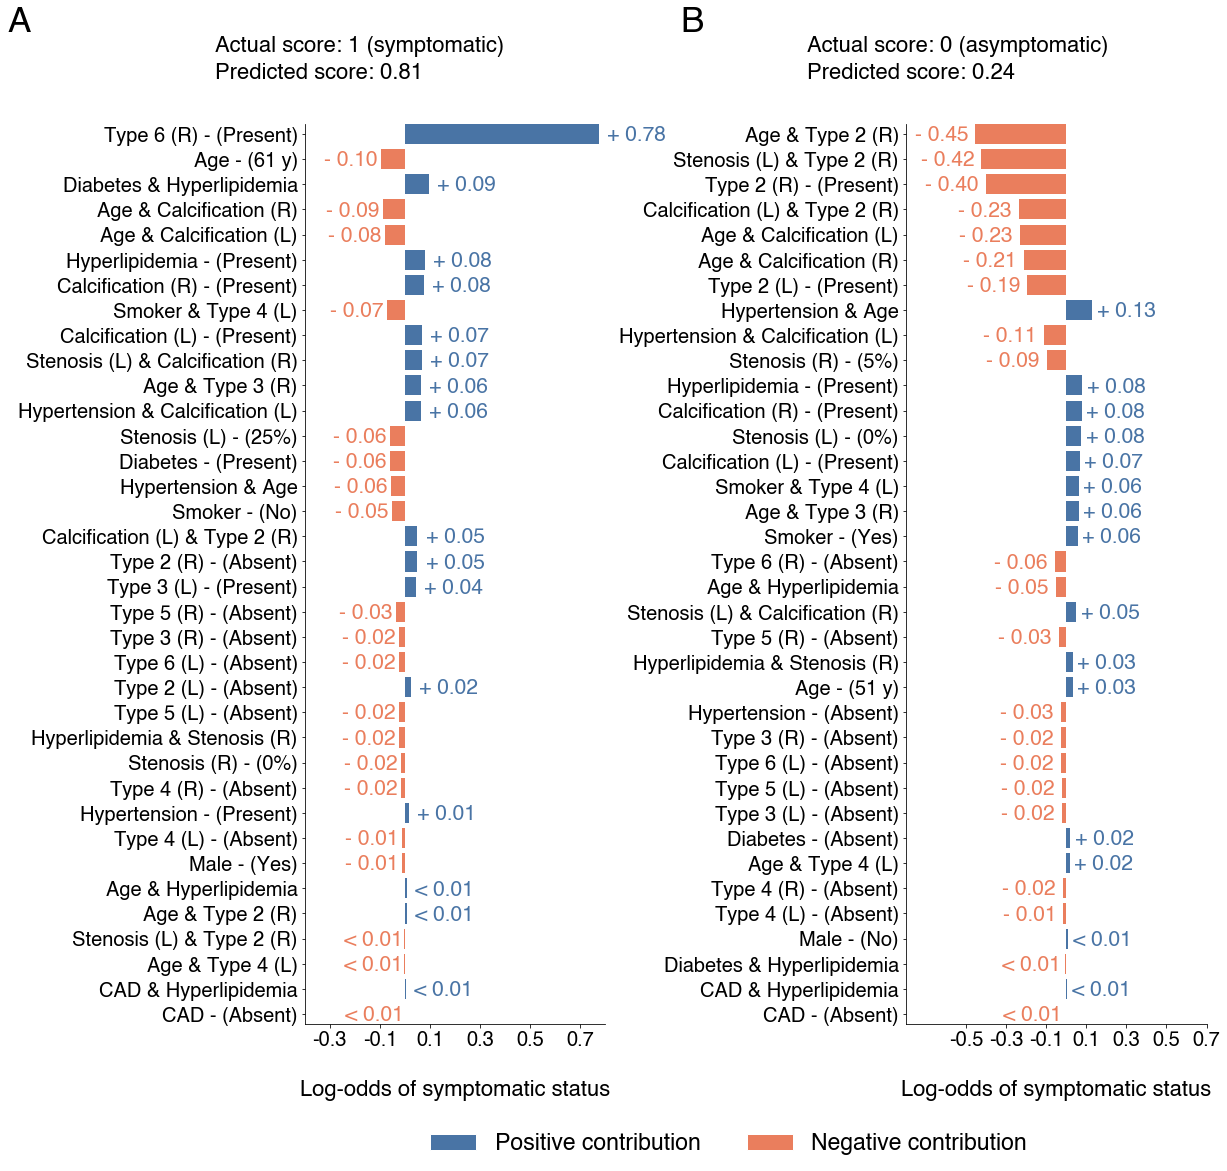

In [1372]:
f, axes = plt.subplots(1, 2, figsize=(17, 15))

## TRUE POSITIVE
colors = [blue_yonder, sienna] # blue, red
legend_labels = ["Positive contribution", "Negative contribution"]
threshold = thresh
tp_index = 98
f, ax1, tp_barplot = plot_local_importances(ebm_all, X_test, y_test, 
                       index=tp_index, colors=colors, 
                       columns_map = COLUMNS_MAP_LESS, 
                       legend_labels = legend_labels, 
                       cat_variables = COLUMNS_TYPES["categorical"],
                       thresh = threshold,
                       thresh_color=violet,
                       display_legend=False,
                       pos_neg_colors = (blue_yonder, sienna),
                       show = "probabilities",
                       show_threshold = False,
                       pos_hoffset = 0.03,
                       ax = axes[0])

"""
ax1.text(x=threshold + 0.17, 
        y=-0.05, 
        s=f"{threshold:.2f}", 
        transform=ax1.transAxes, 
        color=violet,
        fontweight="bold",
        size=20)
"""

ax1.set_xlim([-0.4, 0.8])
new_xticks = np.around(np.arange(-0.3, 0.8, 0.2), 2)
ax1.set_xticks(new_xticks, new_xticks, fontsize=14)

f.text(0, 1, "A", size=35, weight='bold')

# annotate actual and predicted score
local_exp_tp = ebm_all.explain_local(X_test[tp_index:tp_index+1], y_test[tp_index:tp_index+1]).data(key=0)

actual_score_tp = local_exp_tp["perf"]["actual"]
if actual_score_tp == 1:
    actual_tp = f"Actual score: 1 (symptomatic)"
else:
    actual_tp = f"Actual score: 0 (asymptomatic)"
#pred_score_tp = local_exp_tp["perf"]["predicted_score"]
pred_score_tp = ebm_all.predict_proba(X_test[tp_index:tp_index+1])[:, 1].item()
pred_status_tp = "symptomatic" if pred_score_tp >= threshold else "asymptomatic"
predicted_tp = f"Predicted score: {pred_score_tp:.2f}"
#({pred_status_tp})
ax1.text(-0.3, 1.05, predicted_tp, transform=ax1.transAxes, size=22)
ax1.text(-0.3, 1.08, actual_tp, transform=ax1.transAxes, size=22)

rect_tp = plt.Rectangle((180, 1085), 430, 100, linewidth=1, 
                        edgecolor='black', 
                        facecolor='none')
#f.patches.extend([rect_tp])

## TRUE NEGATIVE
tn_index = 51
f, ax2, tn_barplot = plot_local_importances(ebm_all, X_test, y_test, 
                       index=tn_index, colors=colors, 
                       columns_map = COLUMNS_MAP_LESS, 
                       legend_labels = legend_labels, 
                       cat_variables = COLUMNS_TYPES["categorical"],
                       thresh = threshold,
                       thresh_color=violet,
                       display_legend=False,
                       pos_neg_colors = (blue_yonder, sienna),
                       show = "probabilities",
                       show_threshold = False,
                       neg_hoffset = -0.05,
                       pos_hoffset = 0.05,
                       ax = axes[1])
"""
ax2.text(x=threshold + 0.17, 
        y=-0.05, 
        s=f"{threshold:.2f}", 
        transform=ax2.transAxes, 
        color=violet,
        fontweight="bold",
        size=20)
"""

"""
ins = ax2.inset_axes([0.82, 0.8, 0.6, 0.24])
fname = "age & calcification_right_Type2"
fkey = ebm_global.data()["names"].index(fname)
plot_interaction_feature(data=ebm_global.data(key=fkey), 
                                     fname=fname,
                                     columns_map = COLUMNS_MAP,
                                     tick_labels = dict(),
                                     cmap=custom_cmap,
                                     ax=ins)
"""





ax2.set_xlim([-0.8, 0.3])
new_xticks = np.around(np.arange(-0.5, 0.8, 0.2), 2)
ax2.set_xticks(new_xticks, new_xticks, fontsize=14)


f.text(0.55, 1, "B", size=35, weight='bold')

# annotate actual and predicted score
local_exp_tn = ebm_all.explain_local(X_test[tn_index:tn_index+1], y_test[tn_index:tn_index+1]).data(key=0)

actual_score_tn = local_exp_tn["perf"]["actual"]
if actual_score_tn == 1:
    actual_tn = f"Actual score: 1 (symptomatic)"
else:
    actual_tn = f"Actual score: 0 (asymptomatic)"
#pred_score_tn = local_exp_tn["perf"]["predicted_score"]
pred_score_tn = ebm_all.predict_proba(X_test[tn_index:tn_index+1])[:, 1].item()
pred_status_tn = "symptomatic" if pred_score_tn >= threshold else "asymptomatic"
predicted_tn = f"Predicted score: {pred_score_tn:.2f}"
#({pred_status_tn})
ax2.text(-0.33, 1.05, predicted_tn, transform=ax2.transAxes, size=22)
ax2.text(-0.33, 1.08, actual_tn, transform=ax2.transAxes, size=22)

rect_tn = plt.Rectangle((900, 1085), 400, 100, linewidth=1, 
                        edgecolor='black', 
                        facecolor='none')
#f.patches.extend([rect_tn])

#tn_bars = [child for child in tn_barplot.get_children() if not isinstance(child, matplotlib.text.Text)] 


    
# increase fontsize of axes labels and xtick labels
#ax1.set_xlabel("Average absolute impact", fontsize=22)
#ax2.set_xlabel("Average absolute impact", fontsize=22)

ax1.tick_params(axis='both', labelsize=20)
ax2.tick_params(axis='both', labelsize=20)

# add common legend
legend_handles = []
for subset_name, subset_color in zip(legend_labels, colors):
    legend_handles.append(Patch(facecolor=subset_color, 
                                edgecolor="white",
                                label=subset_name))

f.legend(handles=legend_handles, frameon=False, 
         bbox_to_anchor=(0.85, 0), 
         ncol=3,
         prop={"size": 23})

ax1.xaxis.labelpad = 30
ax2.xaxis.labelpad = 30

#plt.tight_layout(w_pad = -6)
plt.tight_layout()
plt.subplots_adjust(wspace=1)
#axes[2].set_position([0.7, 0.1, 0.18, 0.8])

plt.savefig("../output/plots/individualized_predictions.tiff", format="tiff", dpi=500,
                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

plt.show()

In [1373]:
ebm_all.intercept_

array([0.70676192])

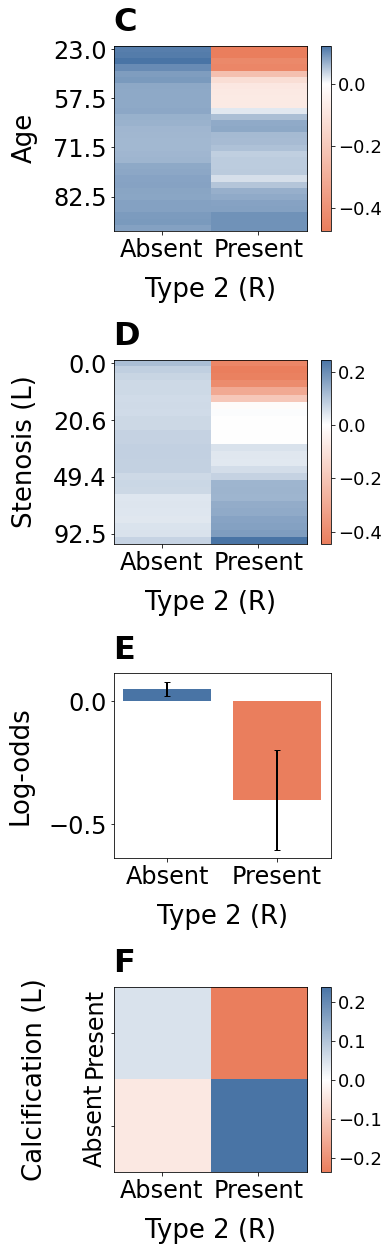

In [31]:
features_to_detail = ["age & calcification_right_Type2", 
                      "stenosis_left & calcification_right_Type2",
                      "calcification_right_Type2",
                      "calcification_left_Type1 & calcification_right_Type2",
                     ]
ebm = load_obj("../output/fitted_models/ebm_all.pkl")
ebm_global = ebm.explain_global()

#custom_cmap = clr.LinearSegmentedColormap.from_list('custom cmap', [green2, "#fff", fire], N=256)
custom_cmap = clr.LinearSegmentedColormap.from_list('custom cmap', [sienna, "#fff", blue_yonder], N=256)

kwargs = dict(figsize = (5.5, 17.5), 
              nrows = 4, ncols = 1,
              tick_every_nth = 8,
              from_letter_idx = 2)
f, axes, plots = plot_learned_features(ebm_global, 
                      features_to_detail, 
                      columns_map = COLUMNS_MAP_LESS,
                      tick_labels = tick_labels,
                      cmap = custom_cmap,
                      colors = [blue_yonder, sienna],
                      ax = None,
                      **kwargs)

#axes[-1].set_yticklabels(axes[-1].get_yticks(), rotation = 90)
axes[-1].set_yticks(axes[-1].get_yticks(), 
                    axes[-1].get_yticklabels(), 
                    rotation=90, ha='right', va="center")

axes[2].set_ylabel("Log-odds")
axes[-1].yaxis.labelpad = 35

plt.tight_layout()
plt.subplots_adjust(hspace=0.7)

#plt.savefig("../output/plots/explain_top4_individualized_tn.tiff", format="tiff", dpi=500,
#                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

In [1004]:
X_test.iloc[98, :], y_test[98]

(hypertension                  1
 cad                           0
 smoker_status                 0
 age                          61
 gender                        1
 diabetes                      1
 hyperlipidemia                1
 stenosis_right                0
 stenosis_left                25
 calcification_left_Type1      0
 calcification_left_Type2      0
 calcification_left_Type3      1
 calcification_left_Type4      0
 calcification_left_Type5      0
 calcification_left_Type6      0
 calcification_right_Type1     0
 calcification_right_Type2     0
 calcification_right_Type3     0
 calcification_right_Type4     0
 calcification_right_Type5     0
 calcification_right_Type6     1
 Name: 98, dtype: int64,
 1)

# Trying to figure out how to convert logits to probabilities

In [94]:
def reshape_X(X, min_cols, n_samples, sample_source):
    if X.ndim == 0 or X.shape[0] == 0: # zero dimensional arrays are possible, but really weird
        return np.empty((0, 0), X.dtype)
    elif X.ndim != 1:
        # our caller will not call this function with 2 dimensions
        # we also accept 1 dimension as below, but do not encourage it
        msg = f"X must have 2 dimensions, but has {X.ndim}"
        _log.error(msg)
        raise ValueError(msg)

    if n_samples is not None:
        if n_samples == 1:
            return X.reshape((1, X.shape[0]))
        elif n_samples == X.shape[0]:
            return X.reshape((n_samples, 1))
        else:
            msg = f"{sample_source} has {n_samples} samples, but X has {X.shape[0]}"
            _log.error(msg)
            raise ValueError(msg)
    elif min_cols is None or min_cols == 1:
        return X.reshape((X.shape[0], 1))
    elif min_cols <= X.shape[0]:
        return X.reshape((1, X.shape[0]))
    else:
        msg = f"X is 1 dimensional"
        _log.error(msg)
        raise ValueError(msg)

def clean_X(X, min_cols=None, n_samples=None, sample_source="y"):
    # called under: fit or predict
    _pandas_installed = True

    if isinstance(X, np.ndarray): # this includes ma.masked_array
        if X.ndim != 2:
            X = reshape_X(X, min_cols, n_samples, sample_source)
        if n_samples is not None and n_samples != X.shape[0]:
            msg = f"{sample_source} has {n_samples} samples, but X has {X.shape[0]}"
            _log.error(msg)
            raise ValueError(msg)
        return X, X.shape[0]
    elif _pandas_installed and isinstance(X, pd.DataFrame):
        if n_samples is not None and n_samples != X.shape[0]:
            msg = f"{sample_source} has {n_samples} samples, but X has {X.shape[0]}"
            _log.error(msg)
            raise ValueError(msg)
        return X, X.shape[0]
    elif _pandas_installed and isinstance(X, pd.Series):
        if min_cols is not None and min_cols != 1:
            msg = "X cannot be a pandas.Series unless there is only 1 feature"
            _log.error(msg)
            raise ValueError(msg)
        if n_samples is not None and n_samples != X.shape[0]:
            msg = f"{sample_source} has {n_samples} samples, but X has {X.shape[0]}"
            _log.error(msg)
            raise ValueError(msg)
        return X, X.shape[0]
    elif _scipy_installed and isinstance(X, sp.sparse.spmatrix):
        if n_samples is not None and n_samples != X.shape[0]:
            msg = f"{sample_source} has {n_samples} samples, but X has {X.shape[0]}"
            _log.error(msg)
            raise ValueError(msg)
        return X, X.shape[0]
    elif isinstance(X, dict):
        for val in X.values():
            if isinstance(val, np.ndarray) and val.ndim == 0:
                break
            # we don't support iterators for dict, so len should work
            if n_samples is not None and n_samples != len(val):
                msg = f"{sample_source} has {n_samples} samples, but X has {X.shape[0]}"
                _log.error(msg)
                raise ValueError(msg)
            return X, len(val)
        if n_samples is not None and n_samples != 0:
            msg = f"{sample_source} has {n_samples} samples, but X has {X.shape[0]}"
            _log.error(msg)
            raise ValueError(msg)
        return X, 0
    elif isinstance(X, list) or isinstance(X, tuple):
        is_copied = False
    elif callable(getattr(X, '__array__', None)):
        X = X.__array__()
        if X.ndim != 2:
            X = reshape_X(X, min_cols, n_samples, sample_source)
        if n_samples is not None and n_samples != X.shape[0]:
            msg = f"{sample_source} has {n_samples} samples, but X has {X.shape[0]}"
            _log.error(msg)
            raise ValueError(msg)
        return X, X.shape[0]
    elif X is None:
        msg = "X cannot be None"
        _log.error(msg)
        raise TypeError(msg)
    elif isinstance(X, str):
        # str objects are iterable, so don't allow them to get to the list() conversion below
        msg = "X cannot be a str type"
        _log.error(msg)
        raise TypeError(msg)
    else:
        try:
            X = list(X)
            is_copied = True
        except TypeError:
            msg = "X must be an iterable"
            _log.error(msg)
            raise TypeError(msg)

    # for consistency with what the caller expects, we should mirror what np.array([[..], [..], .., [..]]) does
    # [1, 2, 3] is one sample with 3 features
    # [[1], [2], [3]] is three samples with 1 feature
    # [[1], [2], 3] is bug prone.  You could argue that it has to be a single sample since
    #   the 3 only makes sense in that context, but if the 2 value was removed it would change 
    #   from being a single sample with 3 features to being two samples with a single feature, 
    #   so force the user to have consistent inner lists/objects

    for idx in range(len(X)):
        sample = X[idx]
        if isinstance(sample, list) or isinstance(sample, tuple):
            pass
        elif isinstance(sample, ma.masked_array):
            # do this before np.ndarray since ma.masked_array is a subclass of np.ndarray
            if not is_copied:
                is_copied = True
                X = list(X)
            X[idx] = _reshape_1D_if_possible(sample.astype(np.object_, copy=False).filled(np.nan))
        elif isinstance(sample, np.ndarray):
            if sample.ndim == 1:
                pass
            else:
                if not is_copied:
                    is_copied = True
                    X = list(X)
                X[idx] = _reshape_1D_if_possible(sample)
        elif _pandas_installed and isinstance(sample, pd.Series):
            if not is_copied:
                is_copied = True
                X = list(X)
            X[idx] = sample.astype(np.object_, copy=False).values
        elif _pandas_installed and isinstance(sample, pd.DataFrame):
            if sample.shape[1] == 1 or sample.shape[0] == 1:
                if not is_copied:
                    is_copied = True
                    X = list(X)
                X[idx] = sample.astype(np.object_, copy=False).values.reshape(-1)
            elif sample.shape[1] == 0 or sample.shape[0] == 0:
                if not is_copied:
                    is_copied = True
                    X = list(X)
                X[idx] = np.empty(0, np.object_)
            else:
                msg = f"Cannot reshape to 1D. Original shape was {sample.shape}"
                _log.error(msg)
                raise ValueError(msg)
        elif _scipy_installed and isinstance(sample, sp.sparse.spmatrix):
            if sample.shape[1] == 1 or sample.shape[0] == 1:
                if not is_copied:
                    is_copied = True
                    X = list(X)
                X[idx] = sample.toarray().reshape(-1)
            elif sample.shape[1] == 0 or sample.shape[0] == 0:
                if not is_copied:
                    is_copied = True
                    X = list(X)
                X[idx] = np.empty(0, np.object_)
            else:
                msg = f"Cannot reshape to 1D. Original shape was {sample.shape}"
                _log.error(msg)
                raise ValueError(msg)
        elif callable(getattr(sample, '__array__', None)):
            sample = sample.__array__()
            if not is_copied:
                is_copied = True
                X = list(X)
            X[idx] = _reshape_1D_if_possible(sample)
        elif isinstance(sample, str):
            break # this only legal if we have one sample
        else:
            try:
                sample = list(sample)
                if not is_copied:
                    is_copied = True
                    X = list(X)
                X[idx] = sample
            except TypeError:
                break # this only legal if we have one sample

    # leave these as np.object_ for now and we'll try to densify per column where we're more likely to 
    # succeed in densification since columns should generally be a single type
    X = np.array(X, np.object_)
    if X.ndim != 2:
        X = reshape_X(X, min_cols, n_samples, sample_source)
    if n_samples is not None and n_samples != X.shape[0]:
        msg = f"{sample_source} has {n_samples} samples, but X has {X.shape[0]}"
        _log.error(msg)
        raise ValueError(msg)
    return X, X.shape[0]

In [95]:
def determine_min_cols(feature_names=None, feature_types=None):
    if feature_types is None:
        return None if feature_names is None else len(feature_names)
    else:
        n_ignored = sum(1 for feature_type in feature_types if feature_type == 'ignore')
        if feature_names is None or len(feature_names) == len(feature_types) or len(feature_names) == len(feature_types) - n_ignored:
            return len(feature_types) - n_ignored
        else:
            msg = f"feature_names has length {len(feature_names)} which does not match the length of feature_types {len(feature_types)}"
            _log.error(msg)
            raise ValueError(msg)

In [96]:
determine_min_cols(ebm_all.feature_names_in_, ebm_all.feature_names_in_)

21

In [179]:
index = 98
X2, n_samples = clean_X(X_test.iloc[index:index+1], 21)

In [180]:
from interpret.glassbox.ebm.bin import ebm_decision_function_and_explain

In [181]:
from sklearn.utils.extmath import softmax

scores, explanations = ebm_decision_function_and_explain(
    X2, 
    n_samples, 
    ebm_all.feature_names_in_, 
    ebm_all.feature_types_in_, 
    ebm_all.bins_, 
    ebm_all.intercept_, 
    ebm_all.term_scores_, 
    ebm_all.term_features_
)
scores= np.c_[np.zeros(scores.shape), scores]
scores = softmax(scores)

In [186]:
sorted(explanations.flatten(), reverse=True)

[0.776092914674102,
 0.09402715821584474,
 0.07930883996766488,
 0.07637826761246824,
 0.06796153776113156,
 0.06760965003277368,
 0.0640310138500792,
 0.06343671284218208,
 0.049655665194455176,
 0.049651881521134415,
 0.04346552833511189,
 0.023636970243608987,
 0.014671500075356947,
 0.007581801191304537,
 0.007409483491142178,
 0.0033676227884993993,
 -0.0008129494577629529,
 -0.005161057952631887,
 -0.005749688016023612,
 -0.011399796164297371,
 -0.013726179384749175,
 -0.01534364841501445,
 -0.01632232799149661,
 -0.022965164942813303,
 -0.023521183733790932,
 -0.02481509720710172,
 -0.024878552055280025,
 -0.0346115968048294,
 -0.05052156181133109,
 -0.05509354613567084,
 -0.05850729824729789,
 -0.05939909067277714,
 -0.07054891504003509,
 -0.079764661773378,
 -0.08708908285136317,
 -0.09574276433550627]

In [155]:
scores[0][1] - sum(explanations.flatten())

0.07599887707647912

In [152]:
logistic_inv(0.07599887730376376)

-2.4979947188218414

In [198]:
sample_scores = np.full(n_samples, ebm_all.intercept_, dtype=np.float64)
sum([sample_scores.item()] + list(explanations.flatten()))

1.4390743085331197

In [204]:
softmax(np.array(
    [0, sum([sample_scores.item()] + list(explanations.flatten()))
    ]).reshape(1,2))

array([[0.19168874, 0.80831126]])

In [220]:
scores, explanations = ebm_all.predict_and_contrib(X_test[index:index+1],
                                             output="logits")
scores, explanations

(array([1.43907431]),
 array([[ 0.0146715 , -0.00081295, -0.05052156, -0.09574276, -0.0113998 ,
         -0.0585073 ,  0.07930884, -0.01632233, -0.05939909,  0.06796154,
          0.02363697,  0.04346553, -0.01372618, -0.02352118, -0.0248151 ,
          0.07637827,  0.04965188, -0.02487855, -0.01534365, -0.0346116 ,
          0.77609291, -0.05509355,  0.06343671,  0.00336762, -0.07054892,
          0.0075818 , -0.07976466, -0.00516106, -0.08708908,  0.00740948,
          0.06403101,  0.09402716, -0.02296516,  0.06760965, -0.00574969,
          0.04965567]]))

In [210]:
sorted([sample_scores.item()] + list(explanations.flatten()), reverse=True)

[0.776092914674102,
 0.7067619237294109,
 0.09402715821584474,
 0.07930883996766488,
 0.07637826761246824,
 0.06796153776113156,
 0.06760965003277368,
 0.0640310138500792,
 0.06343671284218208,
 0.049655665194455176,
 0.049651881521134415,
 0.04346552833511189,
 0.023636970243608987,
 0.014671500075356947,
 0.007581801191304537,
 0.007409483491142178,
 0.0033676227884993993,
 -0.0008129494577629529,
 -0.005161057952631887,
 -0.005749688016023612,
 -0.011399796164297371,
 -0.013726179384749175,
 -0.01534364841501445,
 -0.01632232799149661,
 -0.022965164942813303,
 -0.023521183733790932,
 -0.02481509720710172,
 -0.024878552055280025,
 -0.0346115968048294,
 -0.05052156181133109,
 -0.05509354613567084,
 -0.05850729824729789,
 -0.05939909067277714,
 -0.07054891504003509,
 -0.079764661773378,
 -0.08708908285136317,
 -0.09574276433550627]

In [145]:
local_exp = ebm_all.explain_local(X_test[index:index+1], y_test[index:index+1]).data(key=0)
local_exp

{'type': 'univariate',
 'names': ['hypertension',
  'cad',
  'smoker_status',
  'age',
  'gender',
  'diabetes',
  'hyperlipidemia',
  'stenosis_right',
  'stenosis_left',
  'calcification_left_Type1',
  'calcification_left_Type2',
  'calcification_left_Type3',
  'calcification_left_Type4',
  'calcification_left_Type5',
  'calcification_left_Type6',
  'calcification_right_Type1',
  'calcification_right_Type2',
  'calcification_right_Type3',
  'calcification_right_Type4',
  'calcification_right_Type5',
  'calcification_right_Type6',
  'hypertension & age',
  'hypertension & calcification_left_Type1',
  'cad & hyperlipidemia',
  'smoker_status & calcification_left_Type4',
  'age & hyperlipidemia',
  'age & calcification_left_Type1',
  'age & calcification_left_Type4',
  'age & calcification_right_Type1',
  'age & calcification_right_Type2',
  'age & calcification_right_Type3',
  'diabetes & hyperlipidemia',
  'hyperlipidemia & stenosis_right',
  'stenosis_left & calcification_right_Type1

In [113]:
explanations.flatten().sum()

0.732312384803709

In [107]:
scores

array([1.43907431])

In [104]:
explanations

array([[ 0.0146715 , -0.00081295, -0.05052156, -0.09574276, -0.0113998 ,
        -0.0585073 ,  0.07930884, -0.01632233, -0.05939909,  0.06796154,
         0.02363697,  0.04346553, -0.01372618, -0.02352118, -0.0248151 ,
         0.07637827,  0.04965188, -0.02487855, -0.01534365, -0.0346116 ,
         0.77609291, -0.05509355,  0.06343671,  0.00336762, -0.07054892,
         0.0075818 , -0.07976466, -0.00516106, -0.08708908,  0.00740948,
         0.06403101,  0.09402716, -0.02296516,  0.06760965, -0.00574969,
         0.04965567]])

In [135]:
scores

array([0.77609291])

In [134]:


np.c_[logistic(ebm_all.intercept_), explanations]

array([[ 0.66968527,  0.0146715 , -0.00081295, -0.05052156, -0.09574276,
        -0.0113998 , -0.0585073 ,  0.07930884, -0.01632233, -0.05939909,
         0.06796154,  0.02363697,  0.04346553, -0.01372618, -0.02352118,
        -0.0248151 ,  0.07637827,  0.04965188, -0.02487855, -0.01534365,
        -0.0346116 ,  0.77609291, -0.05509355,  0.06343671,  0.00336762,
        -0.07054892,  0.0075818 , -0.07976466, -0.00516106, -0.08708908,
         0.00740948,  0.06403101,  0.09402716, -0.02296516,  0.06760965,
        -0.00574969,  0.04965567]])

In [117]:
from interpret.glassbox.ebm.bin import eval_terms

for i, (term_idx, bin_indexes) in enumerate(eval_terms(X2, 
                                        n_samples, 
                                        ebm_all.feature_names_in_, 
                                        ebm_all.feature_types_in_, 
                                        ebm_all.bins_, 
                                        ebm_all.term_features_
                                       )):
    scores = ebm_all.term_scores_[term_idx][tuple(bin_indexes)]
    #sample_scores += scores
    #explanations[:, term_idx] = scores
    print(i, scores)

0 [0.0146715]
1 [-0.00081295]
2 [-0.05052156]
3 [-0.09574276]
4 [-0.05509355]
5 [-0.0113998]
6 [-0.0585073]
7 [0.07930884]
8 [0.00336762]
9 [0.0075818]
10 [0.09402716]
11 [-0.01632233]
12 [-0.02296516]
13 [-0.05939909]
14 [0.06796154]
15 [0.06343671]
16 [-0.07976466]
17 [0.02363697]
18 [0.04346553]
19 [-0.01372618]
20 [-0.07054892]
21 [-0.00516106]
22 [-0.02352118]
23 [-0.0248151]
24 [0.07637827]
25 [-0.08708908]
26 [0.06760965]
27 [0.04965188]
28 [0.00740948]
29 [-0.00574969]
30 [0.04965567]
31 [-0.02487855]
32 [0.06403101]
33 [-0.01534365]
34 [-0.0346116]
35 [0.77609291]


In [1748]:
X.shape, X2.shape, n_samples

((790, 21), (1, 21), 1)

In [1731]:
from interpret.utils._binning import determine_min_cols, clean_X, clean_dimensions, typify_classification, construct_bins, bin_native_by_dimension, unify_data2, _deduplicate_bins, normalize_initial_seed
from interpret.glassbox.bin import ebm_decision_function, ebm_decision_function_and_explain, make_boosting_weights, after_boosting, remove_last2, make_bin_weights, trim_tensor, eval_terms

ModuleNotFoundError: No module named 'interpret.utils._binning'

In [1723]:
index = 98
intercept_id2 = ebm_all.explain_local(X_test[index:index+1], y_test[index:index+1]).data(key=0)["extra"]["scores"][0]
contribs_id2 = ebm_all.predict_and_contrib(X_test.iloc[index, :], output="probabilities")[1]

In [1728]:
ebm_all.intercept_

array([0.69659088])

In [1727]:
sum(contribs_id2.reshape(-1, 1).flatten()),  intercept_id2

(0.7034048560073788, 0.6965908755544312)

In [124]:
def logistic(logits):
    if isinstance(logits, list):
        logits = np.array(logits)
    return 1 / (1 + np.exp(-logits))

def logistic_inv(probs):
    if isinstance(probs, list):
        probs = np.array(probs)
        
    return np.log(probs / (1 - probs))

In [1658]:
index = 98
local_exp = ebm_all.explain_local(X_test[index:index+1], y_test[index:index+1]).data(key=0)
local_exp_imps = list(zip(local_exp["names"], logistic(local_exp["scores"]), local_exp["values"]))
local_exp_imps.sort(key=lambda x:abs(x[1]), reverse=True)

In [1682]:
ebm_all.explain_local(X_test[index:index+1], y_test[index:index+1])

In [1661]:
local_exp_imps_sorted = sorted(list(zip(
    local_exp["scores"], 
    np.sign(local_exp["scores"]) * logistic(local_exp["scores"]),
    )) + [(local_exp["extra"]["scores"][0], logistic(local_exp["extra"]["scores"][0]))], 
key=lambda v: abs(v[0]), reverse=True)

local_exp_imps_sorted

[(0.8075068316887337, 0.6915779709387574),
 (0.6965908755544312, 0.6674314924940101),
 (0.1024909973829867, 0.5256003435709953),
 (-0.09835037791895325, -0.47543220560210764),
 (-0.09343670023948547, -0.47665780472771335),
 (0.08705910843129942, 0.5217510407254471),
 (-0.08325121664206589, -0.4791992082353873),
 (0.0830461787403323, 0.5207496207854682),
 (0.08226740150182159, 0.5205552586449204),
 (0.06902772990536876, 0.5172500835475236),
 (-0.06082901283556872, -0.4847974341736961),
 (-0.060127064560259666, -0.4849727608734213),
 (0.056727816345253056, 0.514178152129085),
 (-0.05539949489492295, -0.4861536674147381),
 (0.052909510191223995, 0.5132242926667315),
 (-0.05067063655593033, -0.4873350505306998),
 (-0.050344240897863546, -0.48741659742741794),
 (0.04504017397289904, 0.5112581403527392),
 (0.04062483070245004, 0.510154811108579),
 (-0.038074212490008974, -0.4904825965882634),
 (-0.030827810496959908, -0.4922936576788),
 (-0.025806957967253408, -0.49354861855538773),
 (-0.024

In [1683]:
logistic_inv(sum(y_test) / len(y_test))

-0.44757659345829115

In [1664]:
0.5112581403527392 - 0.510154811108579

0.0011033292441602338

In [1673]:
sum([p[1] for p in local_exp_imps_sorted])

-0.7794365149628355

In [1670]:
logistic_inv(0.8021832112210315)

1.3999957315618108

In [1646]:
[local_exp["extra"]["scores"][0], logistic(local_exp["extra"]["scores"][0])]

[0.6965908755544312, 0.6674314924940101]

In [1644]:
sum(np.sign(local_exp["scores"]) * logistic(local_exp["scores"])) + logistic(local_exp["extra"]["scores"][0])

-0.7794365149628355

In [1637]:
logistic(local_exp["extra"]["scores"][0])

0.6674314924940101

In [1636]:
sum(local_exp["scores"]) + local_exp["extra"]["scores"][0], logistic(sum(local_exp["scores"]) + local_exp["extra"]["scores"][0])

(1.39999573156181, 0.8021832112210315)

In [1640]:
logistic(sum(local_exp["scores"])), sum([logistic(logit) for logit in local_exp["scores"]])

(0.6689422397980591, 18.165545334851902)

# Plots for top 6 important features

In [17]:
ebm = load_obj("../output/fitted_models/ebm_all.pkl")
ebm_global = ebm.explain_global()
ebm_global.data()["names"]

['hypertension',
 'cad',
 'smoker_status',
 'age',
 'gender',
 'diabetes',
 'hyperlipidemia',
 'stenosis_right',
 'stenosis_left',
 'calcification_left_Type1',
 'calcification_left_Type2',
 'calcification_left_Type3',
 'calcification_left_Type4',
 'calcification_left_Type5',
 'calcification_left_Type6',
 'calcification_right_Type1',
 'calcification_right_Type2',
 'calcification_right_Type3',
 'calcification_right_Type4',
 'calcification_right_Type5',
 'calcification_right_Type6',
 'hypertension & age',
 'hypertension & calcification_left_Type1',
 'cad & hyperlipidemia',
 'smoker_status & calcification_left_Type4',
 'age & hyperlipidemia',
 'age & calcification_left_Type1',
 'age & calcification_left_Type4',
 'age & calcification_right_Type1',
 'age & calcification_right_Type2',
 'age & calcification_right_Type3',
 'diabetes & hyperlipidemia',
 'hyperlipidemia & stenosis_right',
 'stenosis_left & calcification_right_Type1',
 'stenosis_left & calcification_right_Type2',
 'calcification_l

In [19]:
# from interpret import show
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

show(ebm_global)

In [1092]:
#X_train[(X_train["age"] <= 50) & (X_train["calcification_right_Type1"] == 1)].calcification_left_Type1

In [349]:
y_test.iloc[[1]]

1    0
Name: symptoms, dtype: int64

In [450]:
scores_logits = np.array([ 0.07592895, -0.15930658, -0.1865329,  -0.2154755,  -0.22506049, -0.24715591,
 -0.24920961, -0.26577673, -0.17496003, -0.1421861,  -0.15295865, -0.09992982,
 -0.08728258, -0.05090658, -0.04510561, -0.04585908, -0.04957889, -0.05939909,
 -0.00301593,  0.00862552,  0.00811171,  0.05587746,  0.06497097,  0.06762621,
  0.06875333,  0.06810224,  0.06579002,  0.05467963,  0.05784352,  0.05514901,
  0.02193043,  0.02325496,  0.00528728,  0.00340622, -0.05671751,  0.0266141,
  0.03366434,  0.03614249,  0.03299602, -0.09851944, -0.21485906, -0.1850853,
 -0.18520047, -0.1837967,  -0.20444154, -0.15268157, -0.13562292,  0.09552086])

In [452]:
scores_logits[scores_logits < 0] = np.nan

In [453]:
scores_logits

array([0.07592895,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.00862552,
       0.00811171, 0.05587746, 0.06497097, 0.06762621, 0.06875333,
       0.06810224, 0.06579002, 0.05467963, 0.05784352, 0.05514901,
       0.02193043, 0.02325496, 0.00528728, 0.00340622,        nan,
       0.0266141 , 0.03366434, 0.03614249, 0.03299602,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.09552086])

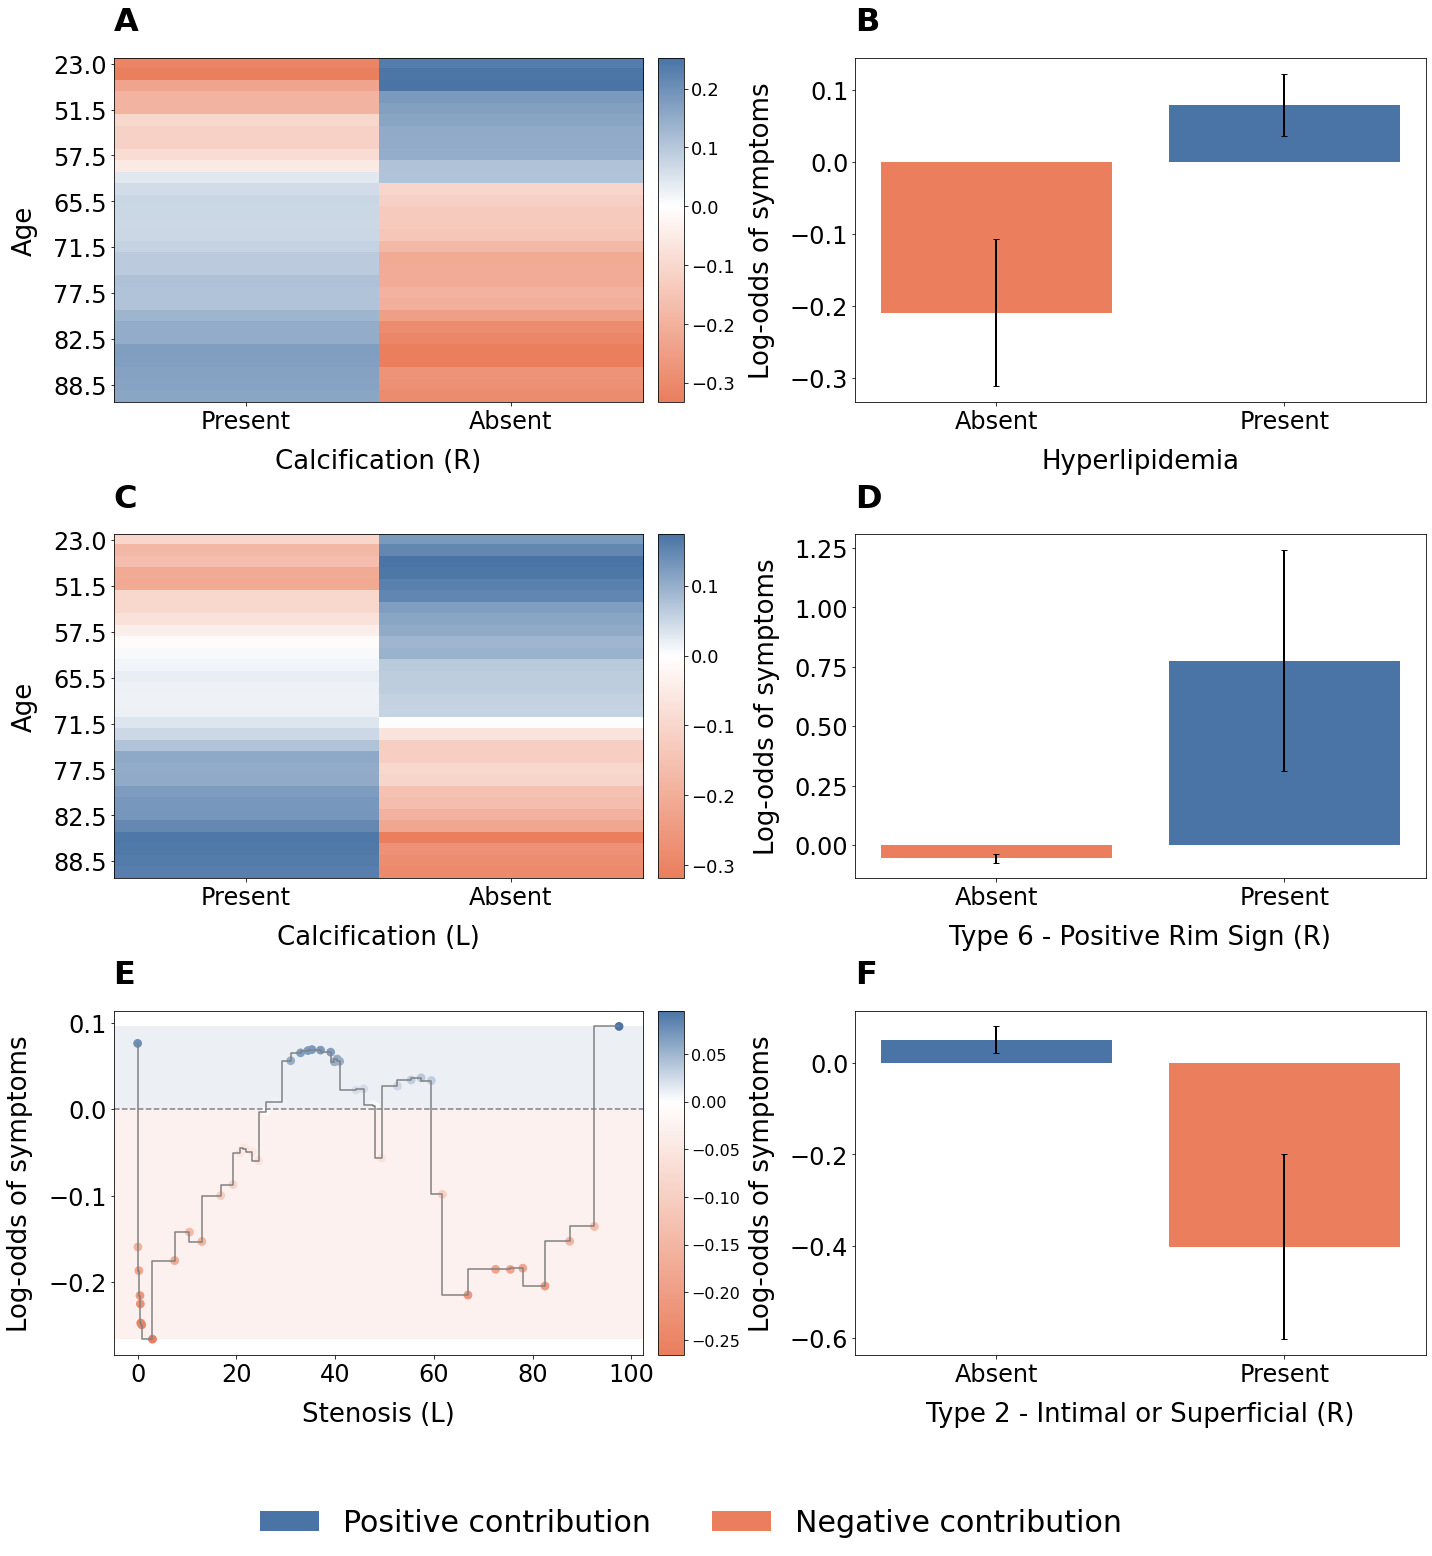

In [36]:
from typing import List
import math
import matplotlib as mpl
from matplotlib import colors as mpl_colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from string import ascii_uppercase
from copy import copy
from matplotlib.patches import Patch

def _plot_continuous_feature(data, fname, columns_map, tick_every_nth, cmap, colors, ax, f):

    #ax.step([p[0] for p in pos], [p[1] for p in pos], color=colors[1])
    #ax.step([p[0] for p in neg], [p[1] for p in neg], color=colors[0])    
    #ax.step(data["names"][:-1], pos, color=colors[1])
    #ax.step(data["names"][:-1], neg, color=colors[0])        
    #ax.step(data["names"][:-1], data["scores"], cmap=cmap)
    norm = mpl_colors.TwoSlopeNorm(vmin=data["scores"].min().item(), 
                               vcenter=0., 
                               vmax=data["scores"].max().item())    

    steps = ax.step(data["names"][:-1], data["scores"], color="gray")
    scatters = ax.scatter(data["names"][:-1], 
                          data["scores"], 
                          s = 60, 
                          c = data["scores"], 
                          norm = norm,
                          cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    #cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    #             cax=cax, 
    #             orientation='vertical', 
    #             #label='Log-odds of symptomatic status'
    #                 )
    cb = f.colorbar(scatters, cax=cax, ticks=[])
    cb.ax.tick_params(labelsize=16)
    cb.ax.set_yscale('linear')
    
    ax.xaxis.labelpad = 15
    ax.set_xlabel(columns_map.get(fname, fname), fontsize=22)
    #ax.set_xticks(range(len(data["names"]))[0::tick_every_nth], 
    #                  data["names"][0::tick_every_nth], 
    #                  fontsize=16)
    
    ax.yaxis.labelpad = 15
    ax.set_ylabel("Log-odds of symptoms", fontsize=22)
    
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    ax.axhline(y=0, color='gray', linestyle='--')
    ax.axhspan(0, data["scores"].max().item(), facecolor=colors[0], alpha=0.1, zorder=-100)
    ax.axhspan(data["scores"].min().item(), 0, facecolor=colors[1], alpha=0.1, zorder=-100)
    
    return ax, steps

def _plot_binary_feature(data, fname, columns_map, tick_labels, colors, ax, f):
    bars = ax.bar(range(2), 
           data["scores"], 
           yerr=[data["scores"] - data["lower_bounds"], 
                 data["upper_bounds"] - data["scores"]],
           color=[colors[1] if s < 0 else colors[0] for s in data["scores"]],
           capsize=3,
           error_kw = dict(linewidth=2))
    
    ax.set_xticks(range(2), 
                  tick_labels.get(fname, ["Absent", "Present"]), 
                  fontsize=18)
    ax.set_xlabel(columns_map.get(fname, fname), fontsize=22)
    ax.xaxis.labelpad = 15
    
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.set_ylabel("Log-odds of symptoms", fontsize=22)
    ax.yaxis.labelpad = 15
    
    return ax, bars

def plot_univariate_feature(data, 
                            fname: str, 
                            columns_map: dict,
                            tick_labels,
                            tick_every_nth: int,
                            cmap,
                            colors,
                            ax = None,
                            f = None):
    if len(data["names"]) == 2:
        ax, plot = _plot_binary_feature(data, fname, columns_map, tick_labels, colors, ax, f)
    elif len(data["names"]) > 2:
        ax, plot = _plot_continuous_feature(data, fname, columns_map, tick_every_nth, cmap, colors, ax, f)
    
    return ax, plot

def plot_interaction_feature(data, 
                             fname: str,
                             columns_map: dict,
                             tick_labels,
                             tick_every_nth: int,
                             cmap,
                             ax = None,
                             f = None):
    fst, snd = [fn.replace(" ", "") for fn in fname.split("&")]
    
    # check if right variable (snd) is continuous and flip them
    if len(data["right_names"]) > 2:
        temp = copy(data["right_names"])
        data["right_names"] = data["left_names"]
        data["left_names"] = temp
        data["scores"] = data["scores"].T
        ylabel = snd
        xlabel = fst
    else:
        ylabel = fst
        xlabel = snd        
        
    
    # determine which is the binary feature (if any)
    if len(data["left_names"]) == 2:
        binary = fst
    elif len(data["right_names"]) == 2:
        binary = snd
    else:
        binary = None
    

    im = ax.imshow(data["scores"], 
              aspect="auto",
              cmap=cmap)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    norm = mpl_colors.TwoSlopeNorm(vmin=data["scores"].min().item(), 
                               vcenter=0., 
                               vmax=data["scores"].max().item())
    cb = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 cax=cax, 
                 orientation='vertical', 
                 #label='Log-odds of symptomatic status'
                     )
    #plt.colorbar(im, cax=cax)    
    cb.ax.tick_params(labelsize=18)
    cb.ax.set_yscale('linear')
    
    ax.set_xticks(range(2),
                  tick_labels.get(xlabel, ["Absent", "Present"]), 
                  fontsize=18)

    ax.set_xlabel(columns_map.get(xlabel, snd), fontsize=22)
    ax.xaxis.labelpad = 15
    
    #print(len(data["left_names"]), data["left_names"], len(data["scores"]))
    if len(data["left_names"]) == 2: # binary feature
        ax.set_yticks(range(2), 
                      tick_labels.get(ylabel, ["Absent", "Present"]), 
                      fontsize=18)
    else:
        #[:-1] do not take the last element
        #[0::4] start from pos 0 and take every four elements
        ax.set_yticks(range(len(data["left_names"][:-1]))[0::tick_every_nth], 
                      list(map(lambda v: round(v, 1), data["left_names"][:-1][0::tick_every_nth])), 
                      fontsize=18)
    ax.set_ylabel(columns_map.get(ylabel, fst), fontsize=22)
    ax.yaxis.labelpad = 15
    
    return ax, im

def plot_learned_features(global_exp, 
                          fnames: List[str], 
                          columns_map = dict(),
                          tick_labels = dict(),
                          cmap = None,
                          colors = None,
                          ax = None,
                          **kwargs):
    plots = []
    axes_ = []
    if not ax:
        ncols = kwargs.pop("ncols", 2)
        nrows = kwargs.pop("nrows", math.ceil(len(fnames) / 2))
        figsize = kwargs.pop("figsize", (20, 20))
        f, ax = plt.subplots(nrows, ncols, figsize=figsize)
    
    from_letter_idx = kwargs.pop("from_letter_idx", 0)
    axes = ax.ravel()
    for fax, fname, letter in zip(axes, fnames, ascii_uppercase[from_letter_idx:]):
        fkey = global_exp.data()["names"].index(fname)
        ftype = global_exp.data(key=fkey)["type"]
        
        if ftype == "univariate":
            ax_, plot = plot_univariate_feature(data=global_exp.data(key=fkey), 
                                    fname=fname,
                                    columns_map = columns_map,
                                    tick_labels = tick_labels,
                                    tick_every_nth = kwargs.get("tick_every_nth", 4),
                                    cmap = cmap,
                                    colors = colors,
                                    ax=fax,
                                    f=f)
        elif ftype == "interaction":
            ax_, plot = plot_interaction_feature(data=global_exp.data(key=fkey), 
                                     fname=fname,
                                     columns_map = columns_map,
                                     tick_labels = tick_labels,
                                     tick_every_nth = kwargs.get("tick_every_nth", 4),
                                     cmap=cmap,
                                     ax=fax,
                                     f=f)
        
        fax.text(0, 1.08, letter, transform=fax.transAxes, size=32, weight='bold')
        fax.tick_params(axis='both', which='major', labelsize=24)
        fax.xaxis.label.set_size(26)
        fax.yaxis.label.set_size(26)
        
        plots.append(plot)
        axes_.append(ax_)
    
    return f, axes_, plots

features_to_detail = ["age & calcification_right_Type1", 
                      "hyperlipidemia",
                      "age & calcification_left_Type1",
                      "calcification_right_Type6",
                      "stenosis_left",
                      "calcification_right_Type2"
                     ]
ebm = load_obj("../output/fitted_models/ebm_all.pkl")
ebm_global = ebm.explain_global()

#custom_cmap = clr.LinearSegmentedColormap.from_list('custom cmap', [green2, "#fff", fire], N=256)
custom_cmap = clr.LinearSegmentedColormap.from_list('custom cmap', [sienna, "#fff", blue_yonder], N=256)

f, axes, plots = plot_learned_features(ebm_global, 
                      features_to_detail, 
                      columns_map = COLUMNS_MAP,
                      tick_labels = tick_labels,
                      cmap = custom_cmap,
                      colors = [blue_yonder, sienna],
                      ax = None)

legend_handles = []
legend_labels = ["Positive contribution", "Negative contribution"]

for subset_name, subset_color in zip(legend_labels, [blue_yonder, sienna]):
    legend_handles.append(Patch(facecolor=subset_color, 
                                edgecolor="white",
                                label=subset_name))

f.legend(handles=legend_handles, frameon=False, 
         bbox_to_anchor=(0.8, -0.03), 
         ncol=3,
         prop={"size": 30})

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

plt.savefig("../output/plots/top6_features.tiff", format="tiff", dpi=500,
                bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

In [420]:
features_to_detail = ["age & calcification_right_Type1", 
                      "hyperlipidemia",
                      "age & calcification_left_Type1",
                      "calcification_right_Type6",
                      "calcification_right_Type1",
                      "stenosis_left",
                     ]
idxs = [ebm_global.data()["names"].index(f) for f in features_to_detail]
idxs

[28, 6, 26, 20, 15, 8]

In [566]:
ebm_global.data(key=28)

{'type': 'interaction',
 'left_names': [23.0,
  38.5,
  45.5,
  49.5,
  51.5,
  53.5,
  55.5,
  56.5,
  57.5,
  59.5,
  61.5,
  63.5,
  65.5,
  67.5,
  68.5,
  69.5,
  71.5,
  72.5,
  73.5,
  75.5,
  77.5,
  78.5,
  80.5,
  81.5,
  82.5,
  84.5,
  85.5,
  86.5,
  88.5,
  92.5,
  102.0],
 'right_names': ['0', '1'],
 'scores': array([[-0.31526553,  0.22959523],
        [-0.3296816 ,  0.24593147],
        [-0.24410871,  0.25233043],
        [-0.21105594,  0.17100488],
        [-0.20951056,  0.15829294],
        [-0.13000506,  0.14941057],
        [-0.14174011,  0.13629627],
        [-0.14294457,  0.13525204],
        [-0.11678193,  0.12884329],
        [-0.08708908,  0.08579506],
        [ 0.0059545 ,  0.08437769],
        [ 0.03071163, -0.13322591],
        [ 0.04474572, -0.14431727],
        [ 0.04393442, -0.15682748],
        [ 0.04190367, -0.15923243],
        [ 0.04235391, -0.16565074],
        [ 0.05240014, -0.1976382 ],
        [ 0.06903965, -0.2306751 ],
        [ 0.0693041 , -0.2

In [ ]:
for i in ids:
    df = pd.DataFrame(columns=["volumes", "logits"])
    df["volumes"] = ebm_global.data(key=i)["names"][:-1]
    df["logits"] = ebm_global.data(key=i)["scores"]
    filename = ebm_global.data()["names"][i]
    print(filename)
    #df.to_csv(f"../input/{filename}.csv", index=False)